# Redes Neurais e Regressão Logística

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

## Ajusta Dados

In [19]:
def normalizeXs(x):
    return x/255

def adicionaColuna1(matrix):
    biasFeature = np.ones(matrix.shape[0])
    inputs = np.c_[biasFeature,matrix]
    return inputs

def transform(conjX,conjY):
    targets = []

    for y in conjY:
        target = [0,0,0,0,0,0,0,0,0,0]
        target[y] = 1
        targets.append(target)

    targets = np.array(targets)
    
    
    vectNormalize = np.vectorize(normalizeXs)
    inputs = vectNormalize(conjX)
#     inputs = adicionaColuna1(inputs)
    
    return (inputs,targets)

## Conjunto de treino

In [20]:
data = np.load('train.npz')
xs, ys = data['xs'], data['ys']

xs.shape #80.000 dados com 3072 features
ys.shape #80.000 dados com o número de uma classe

(80000,)

In [21]:
(inputs, targets) = transform(xs,ys)

In [22]:
inputs

array([[0.46666667, 0.05098039, 0.01960784, ..., 0.31764706, 0.29803922,
        0.29803922],
       [1.        , 1.        , 1.        , ..., 0.28235294, 0.32156863,
        0.27058824],
       [0.35686275, 0.29019608, 0.18039216, ..., 0.40392157, 0.29019608,
        0.1372549 ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.17647059, 0.14901961,
        0.11764706],
       [0.58431373, 0.39607843, 0.31372549, ..., 0.56078431, 0.56078431,
        0.56078431],
       [0.66666667, 0.74117647, 0.76470588, ..., 0.54901961, 0.54901961,
        0.51764706]])

In [23]:
targets

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## Conjunto de validação

In [24]:
dataVal = np.load('val.npz')
xsVal, ysVal = dataVal['xs'], dataVal['ys']

In [25]:
(inputsVal, targetsVal) = transform(xsVal,ysVal)

In [26]:
inputsVal

array([[0.4       , 0.41960784, 0.42352941, ..., 0.4627451 , 0.47058824,
        0.50980392],
       [0.44705882, 0.4745098 , 0.46666667, ..., 0.45098039, 0.42352941,
        0.39215686],
       [0.87843137, 0.97254902, 0.98823529, ..., 0.50196078, 0.55686275,
        0.31764706],
       ...,
       [0.01960784, 0.01960784, 0.01960784, ..., 0.00392157, 0.00392157,
        0.01568627],
       [0.94509804, 0.94117647, 0.97254902, ..., 0.39215686, 0.34509804,
        0.28235294],
       [0.53333333, 0.69803922, 0.9254902 , ..., 0.13333333, 0.19215686,
        0.05882353]])

In [27]:
targetsVal

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

## Implementando com Regressão Logística Multinomial

In [96]:
def calculateZNet(inputs, weights):
    return inputs.dot(weights)

In [97]:
def softmax(Z):
    ZOut = []
    
    for (l,L) in enumerate(Z):

        somaExpLine = 0;
        
        linha = []
        for (c,C) in enumerate(L):
            somaExpLine += np.exp(L[c])
            
        for (c,C) in enumerate(L):
            expClassX = np.exp(L[c])
            softmaxR = expClassX/somaExpLine
            linha.append(softmaxR)
            
        ZOut.append(linha)
            
    return ZOut

In [98]:
def crossEntropy(line, targets):
    entropy = 0
    for (z, ZOutLine) in enumerate(line):
        entropy += targets[z]*np.log(ZOutLine)
        
    return -(entropy)

In [99]:
def costFunction(ZOut, targets):   
    qtdLines = len(ZOut)
    sumEntropies = 0
    for (l,L) in enumerate(ZOut):
        sumEntropies += crossEntropy(L,targets[l])
        
    return sumEntropies/qtdLines
    

In [100]:
def derivativeCostFunction(inputs, ZOut, targets, weights):
    dErro_dOut = np.subtract(ZOut, targets)
    
    dErro_dW = inputs.T.dot(dErro_dOut)
    qtdLinhas = len(inputs)
    
    divide = lambda x : x / qtdLinhas
    
    ajuste_weight = divide(dErro_dW)
        
    return ajuste_weight

In [101]:
def gradientDescent(inputs, weights, targets, ZOut, learningRate):
    dErro = derivativeCostFunction(inputs,ZOut,targets,weights)
    
    v1 = learningRate*dErro
    updatedWeights = np.subtract(weights,v1)
        
    return updatedWeights

#### Classes de execução

In [102]:
class BatchIterator:
    firstItem = 0
    lastItem = 0
    batchSize = 0
    dataSet = []
    firstIteration = True
    iteration = 0
    stopIteration = -1;
  
  
    def __init__(self, batchSize, data, stopIteration):
        self.batchSize = batchSize
        self.firstItem = 0
        self.lastItem = batchSize
        self.dataSet = data
        
        if(stopIteration >= 0):
            self.stopIteration = stopIteration
    
   
    def hasNext(self):
        if self.firstIteration:
            temp = self.firstItem
        else:
            temp = self.firstItem + self.batchSize
        size = len(self.dataSet)
        
        if(self.iteration >= self.stopIteration and self.stopIteration > -1):
            r = False
        else:
            r = size > temp
            
        return r
    
    def prox(self):
        if self.firstIteration:
            self.firstIteration = False
            self.iteration+= 1
            return self.dataSet[self.firstItem:self.lastItem]

        self.firstItem = self.lastItem
        self.lastItem += self.batchSize
        
        self.iteration+= 1

        return self.dataSet[self.firstItem:self.lastItem]
        

In [103]:
def get_randomly_initialized_theta(lines,columns, rand_seed=None):
    rand = np.random.RandomState(seed=rand_seed)
    sigma = np.sqrt(2/(lines + 1))
    return sigma*rand.randn(lines, columns)

In [105]:
## Ploto erro de treino e erro de validacao x epoch
def plot_cost_train_val_by_epoch(costs_by_epoch):
    # Array de tuplas do tipo (id época, custo de validação, custo do batch com menor custo)
    df_cost = pd.DataFrame(costs_by_epoch, columns = ['epoch' , 'training_cost', 'validation_cost'])

    fig, ax = plt.subplots()
    plt.title("Custo de treino e validação pela época")
    plt.xlabel('Época')
    plt.ylabel('Custo')
    ax.plot(df_cost['epoch'], df_cost['training_cost'],label="Treino")
    ax.plot(df_cost['epoch'], df_cost['validation_cost'],'r--',label="Validação")
    ax.legend()
    plt.show()

## Classes de execução Regressão Logística

In [104]:
def train(epochs,weights,learningRate,batchSize,dataSet,batchIterations):        
    cost_by_epoch = list()

    for i in range(epochs):
        epochInitTime = datetime.datetime.now()
        iterator = BatchIterator(batchSize, dataSet,batchIterations)
        targetIterator = BatchIterator(batchSize, targets, batchIterations)

        bestCost = -1;
        cost_by_batch = list()
        batchIndex = 0

        while iterator.hasNext():
            initTime = datetime.datetime.now()

            batch = iterator.prox()
            batchTargets = targetIterator.prox()

            ZNet = calculateZNet(batch,weights)
            ZOut = softmax(ZNet)

            updatedWeights = gradientDescent(batch, weights, batchTargets, ZOut, learningRate)
            weights = updatedWeights

            cost = costFunction(ZOut, batchTargets)

            batchIndex+=1
            cost_by_batch.append((batchIndex, cost))

#             if(bestCost == -1 or cost < bestCost):
            bestCost = cost
#                 weights = updatedWeights

            endTime = datetime.datetime.now()

            print("Batch execution time:", endTime - initTime)

        print("cost_by_batch:", cost_by_batch)
        #Plota os custos por batch da época
        df_cost_batch = pd.DataFrame(cost_by_batch, columns = ['batch' , 'cost',])
        fig, ax = plt.subplots()
        plt.title("Custo dos batchs de treinamento da época " + str(i))
        plt.xlabel('Batch')
        plt.ylabel('Custo')
        ax.plot(df_cost_batch['batch'], df_cost_batch['cost'])
        ax.legend()
        plt.show()

        # Validação
        ZNetVal = calculateZNet(inputsVal,weights)
        ZOutVal = softmax(ZNetVal)

        cost_val = costFunction(ZOutVal, targetsVal)

        cost_by_epoch.append((i, bestCost, cost_val))

        epochEndTime = datetime.datetime.now()
        print("Epoch execution time:", epochEndTime - epochInitTime)

    print("Cost by Epoch:", cost_by_epoch)
    return (cost_by_epoch, weights)

# Executando

In [106]:
weights1 = get_randomly_initialized_theta(3072,10,345)

Batch execution time: 0:00:00.126523
Batch execution time: 0:00:00.084886
Batch execution time: 0:00:00.083826
Batch execution time: 0:00:00.101226
Batch execution time: 0:00:00.085526
Batch execution time: 0:00:00.083035
Batch execution time: 0:00:00.106850
Batch execution time: 0:00:00.091039
Batch execution time: 0:00:00.088856
Batch execution time: 0:00:00.097659
Batch execution time: 0:00:00.082271
Batch execution time: 0:00:00.094041
Batch execution time: 0:00:00.095622
Batch execution time: 0:00:00.088838
Batch execution time: 0:00:00.085248
Batch execution time: 0:00:00.098143
Batch execution time: 0:00:00.083799
Batch execution time: 0:00:00.085242
Batch execution time: 0:00:00.099633
Batch execution time: 0:00:00.082651
Batch execution time: 0:00:00.082734
Batch execution time: 0:00:00.119805
Batch execution time: 0:00:00.088490
Batch execution time: 0:00:00.089415
Batch execution time: 0:00:00.093987
Batch execution time: 0:00:00.082836
Batch execution time: 0:00:00.085019
B

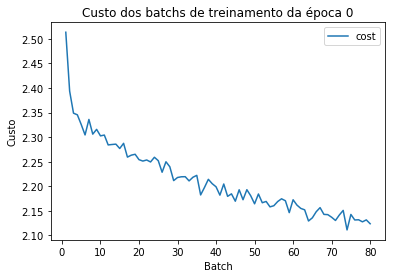

Epoch execution time: 0:00:08.056698
Batch execution time: 0:00:00.087426
Batch execution time: 0:00:00.088076
Batch execution time: 0:00:00.090413
Batch execution time: 0:00:00.085850
Batch execution time: 0:00:00.084689
Batch execution time: 0:00:00.091074
Batch execution time: 0:00:00.085823
Batch execution time: 0:00:00.085494
Batch execution time: 0:00:00.091826
Batch execution time: 0:00:00.085863
Batch execution time: 0:00:00.085070
Batch execution time: 0:00:00.093135
Batch execution time: 0:00:00.084835
Batch execution time: 0:00:00.085967
Batch execution time: 0:00:00.092542
Batch execution time: 0:00:00.086224
Batch execution time: 0:00:00.085822
Batch execution time: 0:00:00.093163
Batch execution time: 0:00:00.084171
Batch execution time: 0:00:00.083105
Batch execution time: 0:00:00.090810
Batch execution time: 0:00:00.086777
Batch execution time: 0:00:00.087513
Batch execution time: 0:00:00.094264
Batch execution time: 0:00:00.085849
Batch execution time: 0:00:00.084119
B

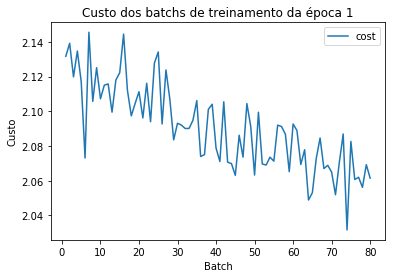

Epoch execution time: 0:00:07.942480
Batch execution time: 0:00:00.086060
Batch execution time: 0:00:00.086523
Batch execution time: 0:00:00.090879
Batch execution time: 0:00:00.085898
Batch execution time: 0:00:00.083665
Batch execution time: 0:00:00.090155
Batch execution time: 0:00:00.085246
Batch execution time: 0:00:00.085148
Batch execution time: 0:00:00.090686
Batch execution time: 0:00:00.085208
Batch execution time: 0:00:00.083049
Batch execution time: 0:00:00.090152
Batch execution time: 0:00:00.085174
Batch execution time: 0:00:00.085061
Batch execution time: 0:00:00.092241
Batch execution time: 0:00:00.084893
Batch execution time: 0:00:00.084998
Batch execution time: 0:00:00.090469
Batch execution time: 0:00:00.084341
Batch execution time: 0:00:00.087913
Batch execution time: 0:00:00.090589
Batch execution time: 0:00:00.084995
Batch execution time: 0:00:00.085421
Batch execution time: 0:00:00.090005
Batch execution time: 0:00:00.084817
Batch execution time: 0:00:00.084274
B

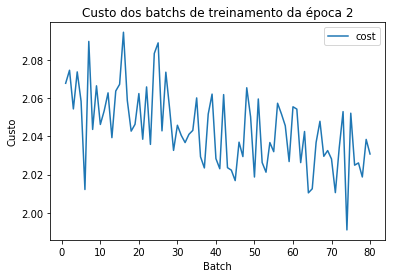

Epoch execution time: 0:00:07.988958
Batch execution time: 0:00:00.084810
Batch execution time: 0:00:00.085806
Batch execution time: 0:00:00.091135
Batch execution time: 0:00:00.084701
Batch execution time: 0:00:00.085904
Batch execution time: 0:00:00.091886
Batch execution time: 0:00:00.084372
Batch execution time: 0:00:00.085082
Batch execution time: 0:00:00.091172
Batch execution time: 0:00:00.085728
Batch execution time: 0:00:00.087044
Batch execution time: 0:00:00.091542
Batch execution time: 0:00:00.088410
Batch execution time: 0:00:00.084036
Batch execution time: 0:00:00.092898
Batch execution time: 0:00:00.085352
Batch execution time: 0:00:00.086062
Batch execution time: 0:00:00.091145
Batch execution time: 0:00:00.085990
Batch execution time: 0:00:00.087551
Batch execution time: 0:00:00.090271
Batch execution time: 0:00:00.086165
Batch execution time: 0:00:00.086195
Batch execution time: 0:00:00.093948
Batch execution time: 0:00:00.085153
Batch execution time: 0:00:00.087077
B

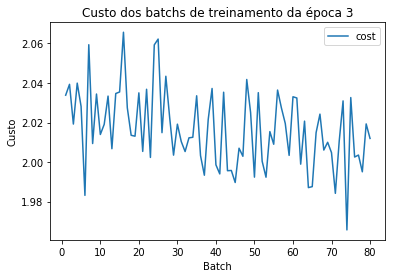

Epoch execution time: 0:00:08.084095
Batch execution time: 0:00:00.085326
Batch execution time: 0:00:00.084360
Batch execution time: 0:00:00.091736
Batch execution time: 0:00:00.085307
Batch execution time: 0:00:00.084786
Batch execution time: 0:00:00.092117
Batch execution time: 0:00:00.086670
Batch execution time: 0:00:00.085576
Batch execution time: 0:00:00.088931
Batch execution time: 0:00:00.085630
Batch execution time: 0:00:00.085189
Batch execution time: 0:00:00.092863
Batch execution time: 0:00:00.086412
Batch execution time: 0:00:00.085905
Batch execution time: 0:00:00.090660
Batch execution time: 0:00:00.087266
Batch execution time: 0:00:00.083989
Batch execution time: 0:00:00.090596
Batch execution time: 0:00:00.086352
Batch execution time: 0:00:00.087443
Batch execution time: 0:00:00.092165
Batch execution time: 0:00:00.083285
Batch execution time: 0:00:00.083847
Batch execution time: 0:00:00.092611
Batch execution time: 0:00:00.084857
Batch execution time: 0:00:00.087558
B

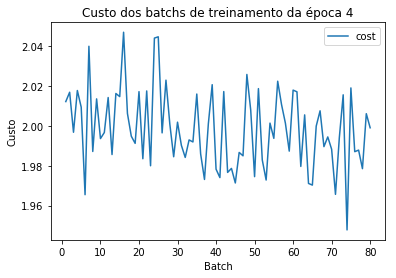

Epoch execution time: 0:00:07.945456
Batch execution time: 0:00:00.084953
Batch execution time: 0:00:00.085601
Batch execution time: 0:00:00.091828
Batch execution time: 0:00:00.085533
Batch execution time: 0:00:00.084684
Batch execution time: 0:00:00.091799
Batch execution time: 0:00:00.084467
Batch execution time: 0:00:00.084812
Batch execution time: 0:00:00.090596
Batch execution time: 0:00:00.085315
Batch execution time: 0:00:00.085793
Batch execution time: 0:00:00.091896
Batch execution time: 0:00:00.086288
Batch execution time: 0:00:00.086010
Batch execution time: 0:00:00.091674
Batch execution time: 0:00:00.085150
Batch execution time: 0:00:00.085421
Batch execution time: 0:00:00.092978
Batch execution time: 0:00:00.085896
Batch execution time: 0:00:00.084395
Batch execution time: 0:00:00.091083
Batch execution time: 0:00:00.088634
Batch execution time: 0:00:00.085459
Batch execution time: 0:00:00.093241
Batch execution time: 0:00:00.085679
Batch execution time: 0:00:00.086093
B

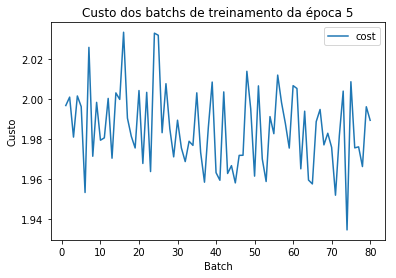

Epoch execution time: 0:00:07.971379
Batch execution time: 0:00:00.085400
Batch execution time: 0:00:00.083875
Batch execution time: 0:00:00.089948
Batch execution time: 0:00:00.085630
Batch execution time: 0:00:00.087278
Batch execution time: 0:00:00.090734
Batch execution time: 0:00:00.099964
Batch execution time: 0:00:00.083471
Batch execution time: 0:00:00.090228
Batch execution time: 0:00:00.086882
Batch execution time: 0:00:00.085517
Batch execution time: 0:00:00.090691
Batch execution time: 0:00:00.085476
Batch execution time: 0:00:00.085610
Batch execution time: 0:00:00.090935
Batch execution time: 0:00:00.085971
Batch execution time: 0:00:00.087702
Batch execution time: 0:00:00.098769
Batch execution time: 0:00:00.088496
Batch execution time: 0:00:00.085055
Batch execution time: 0:00:00.091302
Batch execution time: 0:00:00.085915
Batch execution time: 0:00:00.085461
Batch execution time: 0:00:00.092281
Batch execution time: 0:00:00.086658
Batch execution time: 0:00:00.085803
B

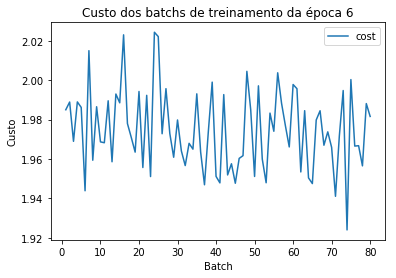

Epoch execution time: 0:00:08.000407
Batch execution time: 0:00:00.085264
Batch execution time: 0:00:00.086333
Batch execution time: 0:00:00.092581
Batch execution time: 0:00:00.082495
Batch execution time: 0:00:00.084978
Batch execution time: 0:00:00.092182
Batch execution time: 0:00:00.085002
Batch execution time: 0:00:00.098305
Batch execution time: 0:00:00.089174
Batch execution time: 0:00:00.085332
Batch execution time: 0:00:00.085623
Batch execution time: 0:00:00.095357
Batch execution time: 0:00:00.085306
Batch execution time: 0:00:00.083986
Batch execution time: 0:00:00.092893
Batch execution time: 0:00:00.085469
Batch execution time: 0:00:00.087579
Batch execution time: 0:00:00.090798
Batch execution time: 0:00:00.085236
Batch execution time: 0:00:00.087271
Batch execution time: 0:00:00.092235
Batch execution time: 0:00:00.087650
Batch execution time: 0:00:00.086648
Batch execution time: 0:00:00.091927
Batch execution time: 0:00:00.084304
Batch execution time: 0:00:00.087820
B

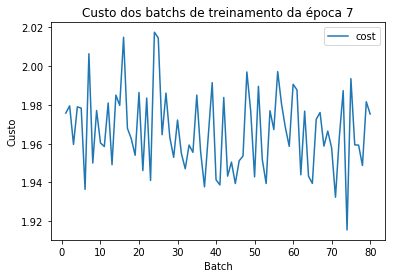

Epoch execution time: 0:00:08.024913
Batch execution time: 0:00:00.083388
Batch execution time: 0:00:00.084101
Batch execution time: 0:00:00.090452
Batch execution time: 0:00:00.086388
Batch execution time: 0:00:00.085789
Batch execution time: 0:00:00.088780
Batch execution time: 0:00:00.082170
Batch execution time: 0:00:00.082135
Batch execution time: 0:00:00.089372
Batch execution time: 0:00:00.083771
Batch execution time: 0:00:00.085600
Batch execution time: 0:00:00.090192
Batch execution time: 0:00:00.083041
Batch execution time: 0:00:00.084033
Batch execution time: 0:00:00.089888
Batch execution time: 0:00:00.085592
Batch execution time: 0:00:00.085192
Batch execution time: 0:00:00.089013
Batch execution time: 0:00:00.081630
Batch execution time: 0:00:00.082562
Batch execution time: 0:00:00.089118
Batch execution time: 0:00:00.083933
Batch execution time: 0:00:00.085991
Batch execution time: 0:00:00.091179
Batch execution time: 0:00:00.083278
Batch execution time: 0:00:00.084081
B

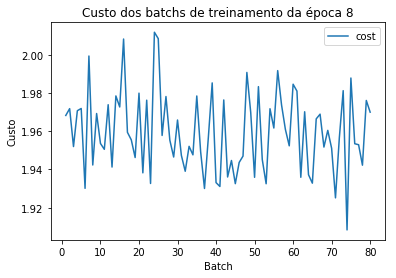

Epoch execution time: 0:00:07.841496
Batch execution time: 0:00:00.084717
Batch execution time: 0:00:00.084975
Batch execution time: 0:00:00.090821
Batch execution time: 0:00:00.085823
Batch execution time: 0:00:00.085917
Batch execution time: 0:00:00.090479
Batch execution time: 0:00:00.086126
Batch execution time: 0:00:00.084161
Batch execution time: 0:00:00.090292
Batch execution time: 0:00:00.085265
Batch execution time: 0:00:00.084795
Batch execution time: 0:00:00.090380
Batch execution time: 0:00:00.086321
Batch execution time: 0:00:00.084729
Batch execution time: 0:00:00.090636
Batch execution time: 0:00:00.085629
Batch execution time: 0:00:00.085336
Batch execution time: 0:00:00.091308
Batch execution time: 0:00:00.085764
Batch execution time: 0:00:00.084383
Batch execution time: 0:00:00.089203
Batch execution time: 0:00:00.085826
Batch execution time: 0:00:00.084722
Batch execution time: 0:00:00.091752
Batch execution time: 0:00:00.085466
Batch execution time: 0:00:00.083834
B

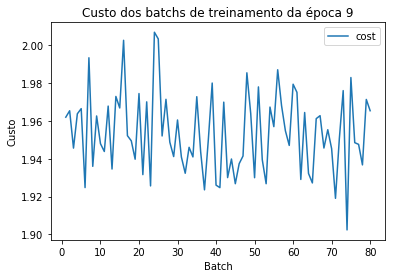

Epoch execution time: 0:00:07.988157
Batch execution time: 0:00:00.085310
Batch execution time: 0:00:00.085550
Batch execution time: 0:00:00.091635
Batch execution time: 0:00:00.084837
Batch execution time: 0:00:00.084641
Batch execution time: 0:00:00.091798
Batch execution time: 0:00:00.086078
Batch execution time: 0:00:00.086027
Batch execution time: 0:00:00.091852
Batch execution time: 0:00:00.084546
Batch execution time: 0:00:00.083213
Batch execution time: 0:00:00.091472
Batch execution time: 0:00:00.086131
Batch execution time: 0:00:00.086743
Batch execution time: 0:00:00.091049
Batch execution time: 0:00:00.084172
Batch execution time: 0:00:00.082497
Batch execution time: 0:00:00.091798
Batch execution time: 0:00:00.086551
Batch execution time: 0:00:00.086460
Batch execution time: 0:00:00.090389
Batch execution time: 0:00:00.086058
Batch execution time: 0:00:00.084027
Batch execution time: 0:00:00.091328
Batch execution time: 0:00:00.085016
Batch execution time: 0:00:00.085825
B

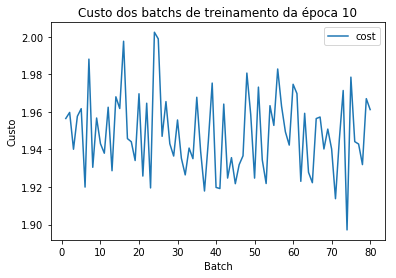

Epoch execution time: 0:00:07.971937
Batch execution time: 0:00:00.084506
Batch execution time: 0:00:00.084231
Batch execution time: 0:00:00.089996
Batch execution time: 0:00:00.083760
Batch execution time: 0:00:00.083642
Batch execution time: 0:00:00.091196
Batch execution time: 0:00:00.084488
Batch execution time: 0:00:00.084146
Batch execution time: 0:00:00.089346
Batch execution time: 0:00:00.084064
Batch execution time: 0:00:00.084053
Batch execution time: 0:00:00.091542
Batch execution time: 0:00:00.084045
Batch execution time: 0:00:00.085034
Batch execution time: 0:00:00.090556
Batch execution time: 0:00:00.081502
Batch execution time: 0:00:00.083032
Batch execution time: 0:00:00.090824
Batch execution time: 0:00:00.084517
Batch execution time: 0:00:00.084774
Batch execution time: 0:00:00.090123
Batch execution time: 0:00:00.083403
Batch execution time: 0:00:00.085654
Batch execution time: 0:00:00.091238
Batch execution time: 0:00:00.084396
Batch execution time: 0:00:00.084731
B

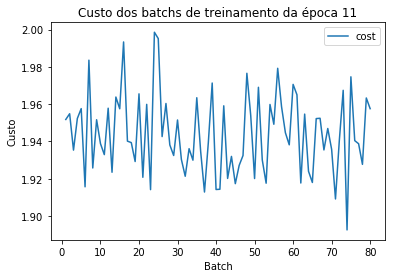

Epoch execution time: 0:00:07.876250
Batch execution time: 0:00:00.084121
Batch execution time: 0:00:00.085456
Batch execution time: 0:00:00.090278
Batch execution time: 0:00:00.084203
Batch execution time: 0:00:00.084237
Batch execution time: 0:00:00.091686
Batch execution time: 0:00:00.085239
Batch execution time: 0:00:00.086054
Batch execution time: 0:00:00.091788
Batch execution time: 0:00:00.086011
Batch execution time: 0:00:00.085956
Batch execution time: 0:00:00.089345
Batch execution time: 0:00:00.084797
Batch execution time: 0:00:00.085598
Batch execution time: 0:00:00.091136
Batch execution time: 0:00:00.085529
Batch execution time: 0:00:00.095114
Batch execution time: 0:00:00.090237
Batch execution time: 0:00:00.083853
Batch execution time: 0:00:00.085161
Batch execution time: 0:00:00.092138
Batch execution time: 0:00:00.087549
Batch execution time: 0:00:00.085896
Batch execution time: 0:00:00.092902
Batch execution time: 0:00:00.083094
Batch execution time: 0:00:00.086826
B

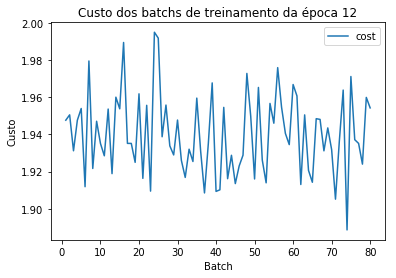

Epoch execution time: 0:00:07.948430
Batch execution time: 0:00:00.087395
Batch execution time: 0:00:00.086384
Batch execution time: 0:00:00.091116
Batch execution time: 0:00:00.083104
Batch execution time: 0:00:00.083851
Batch execution time: 0:00:00.091340
Batch execution time: 0:00:00.085827
Batch execution time: 0:00:00.086290
Batch execution time: 0:00:00.091224
Batch execution time: 0:00:00.087348
Batch execution time: 0:00:00.083992
Batch execution time: 0:00:00.093390
Batch execution time: 0:00:00.085590
Batch execution time: 0:00:00.087365
Batch execution time: 0:00:00.092723
Batch execution time: 0:00:00.086832
Batch execution time: 0:00:00.085626
Batch execution time: 0:00:00.094021
Batch execution time: 0:00:00.084898
Batch execution time: 0:00:00.086099
Batch execution time: 0:00:00.093177
Batch execution time: 0:00:00.087539
Batch execution time: 0:00:00.086852
Batch execution time: 0:00:00.093980
Batch execution time: 0:00:00.081548
Batch execution time: 0:00:00.084428
B

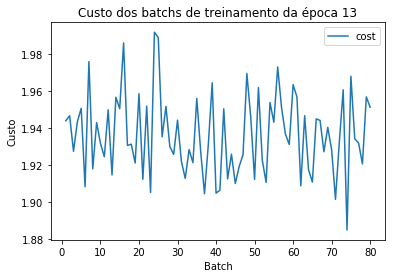

Epoch execution time: 0:00:07.985239
Batch execution time: 0:00:00.085231
Batch execution time: 0:00:00.085504
Batch execution time: 0:00:00.091168
Batch execution time: 0:00:00.084157
Batch execution time: 0:00:00.083558
Batch execution time: 0:00:00.090003
Batch execution time: 0:00:00.084768
Batch execution time: 0:00:00.084798
Batch execution time: 0:00:00.090830
Batch execution time: 0:00:00.086521
Batch execution time: 0:00:00.084369
Batch execution time: 0:00:00.089427
Batch execution time: 0:00:00.087783
Batch execution time: 0:00:00.084370
Batch execution time: 0:00:00.090700
Batch execution time: 0:00:00.084767
Batch execution time: 0:00:00.085771
Batch execution time: 0:00:00.093256
Batch execution time: 0:00:00.082778
Batch execution time: 0:00:00.082971
Batch execution time: 0:00:00.092113
Batch execution time: 0:00:00.085847
Batch execution time: 0:00:00.085630
Batch execution time: 0:00:00.093064
Batch execution time: 0:00:00.081853
Batch execution time: 0:00:00.083339
B

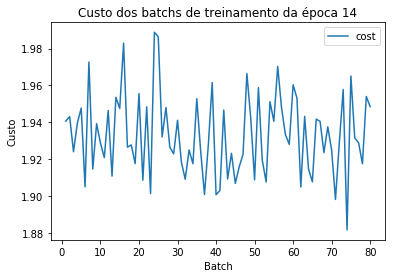

Epoch execution time: 0:00:07.932929
Batch execution time: 0:00:00.085597
Batch execution time: 0:00:00.086931
Batch execution time: 0:00:00.092321
Batch execution time: 0:00:00.084017
Batch execution time: 0:00:00.082777
Batch execution time: 0:00:00.092779
Batch execution time: 0:00:00.085738
Batch execution time: 0:00:00.087871
Batch execution time: 0:00:00.092619
Batch execution time: 0:00:00.085296
Batch execution time: 0:00:00.083880
Batch execution time: 0:00:00.092621
Batch execution time: 0:00:00.085041
Batch execution time: 0:00:00.087025
Batch execution time: 0:00:00.091504
Batch execution time: 0:00:00.085821
Batch execution time: 0:00:00.086370
Batch execution time: 0:00:00.089670
Batch execution time: 0:00:00.087659
Batch execution time: 0:00:00.086530
Batch execution time: 0:00:00.091786
Batch execution time: 0:00:00.085663
Batch execution time: 0:00:00.086663
Batch execution time: 0:00:00.092254
Batch execution time: 0:00:00.083996
Batch execution time: 0:00:00.085271
B

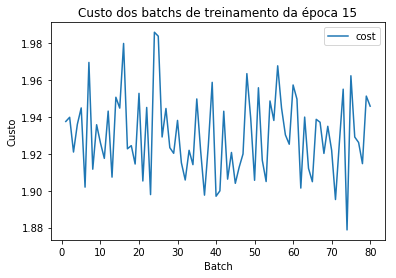

Epoch execution time: 0:00:07.998633
Batch execution time: 0:00:00.082877
Batch execution time: 0:00:00.084571
Batch execution time: 0:00:00.091225
Batch execution time: 0:00:00.083583
Batch execution time: 0:00:00.084923
Batch execution time: 0:00:00.091470
Batch execution time: 0:00:00.082519
Batch execution time: 0:00:00.084473
Batch execution time: 0:00:00.093985
Batch execution time: 0:00:00.086183
Batch execution time: 0:00:00.086255
Batch execution time: 0:00:00.091831
Batch execution time: 0:00:00.084475
Batch execution time: 0:00:00.084424
Batch execution time: 0:00:00.093319
Batch execution time: 0:00:00.085242
Batch execution time: 0:00:00.086361
Batch execution time: 0:00:00.089670
Batch execution time: 0:00:00.085007
Batch execution time: 0:00:00.085698
Batch execution time: 0:00:00.091134
Batch execution time: 0:00:00.085008
Batch execution time: 0:00:00.085488
Batch execution time: 0:00:00.091159
Batch execution time: 0:00:00.085224
Batch execution time: 0:00:00.085126
B

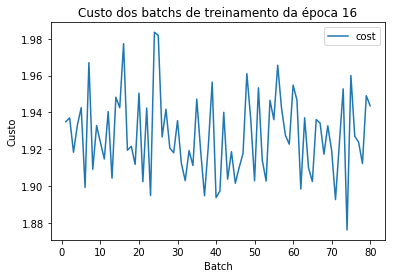

Epoch execution time: 0:00:07.943639
Batch execution time: 0:00:00.088307
Batch execution time: 0:00:00.099593
Batch execution time: 0:00:00.130712
Batch execution time: 0:00:00.156607
Batch execution time: 0:00:00.095349
Batch execution time: 0:00:00.090030
Batch execution time: 0:00:00.085533
Batch execution time: 0:00:00.092112
Batch execution time: 0:00:00.084567
Batch execution time: 0:00:00.085616
Batch execution time: 0:00:00.091258
Batch execution time: 0:00:00.083629
Batch execution time: 0:00:00.083168
Batch execution time: 0:00:00.089853
Batch execution time: 0:00:00.084734
Batch execution time: 0:00:00.085434
Batch execution time: 0:00:00.097268
Batch execution time: 0:00:00.091666
Batch execution time: 0:00:00.082136
Batch execution time: 0:00:00.087446
Batch execution time: 0:00:00.082916
Batch execution time: 0:00:00.082541
Batch execution time: 0:00:00.090409
Batch execution time: 0:00:00.082420
Batch execution time: 0:00:00.083046
Batch execution time: 0:00:00.088764
B

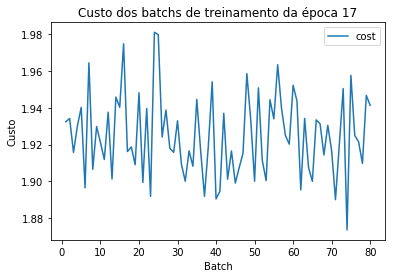

Epoch execution time: 0:00:07.975526
Batch execution time: 0:00:00.084067
Batch execution time: 0:00:00.083897
Batch execution time: 0:00:00.088874
Batch execution time: 0:00:00.082540
Batch execution time: 0:00:00.084897
Batch execution time: 0:00:00.088939
Batch execution time: 0:00:00.083534
Batch execution time: 0:00:00.083122
Batch execution time: 0:00:00.088448
Batch execution time: 0:00:00.083468
Batch execution time: 0:00:00.084955
Batch execution time: 0:00:00.090279
Batch execution time: 0:00:00.084848
Batch execution time: 0:00:00.083484
Batch execution time: 0:00:00.089264
Batch execution time: 0:00:00.082862
Batch execution time: 0:00:00.085192
Batch execution time: 0:00:00.089378
Batch execution time: 0:00:00.083627
Batch execution time: 0:00:00.084024
Batch execution time: 0:00:00.090046
Batch execution time: 0:00:00.083747
Batch execution time: 0:00:00.084663
Batch execution time: 0:00:00.090612
Batch execution time: 0:00:00.083588
Batch execution time: 0:00:00.083895
B

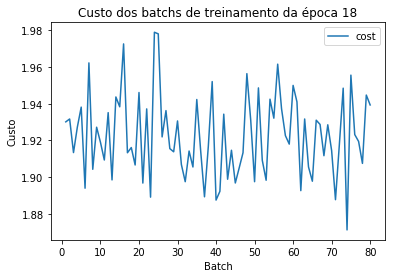

Epoch execution time: 0:00:07.867608
Batch execution time: 0:00:00.084881
Batch execution time: 0:00:00.084036
Batch execution time: 0:00:00.102366
Batch execution time: 0:00:00.090172
Batch execution time: 0:00:00.081604
Batch execution time: 0:00:00.087042
Batch execution time: 0:00:00.081504
Batch execution time: 0:00:00.081843
Batch execution time: 0:00:00.087297
Batch execution time: 0:00:00.082704
Batch execution time: 0:00:00.081527
Batch execution time: 0:00:00.087185
Batch execution time: 0:00:00.082597
Batch execution time: 0:00:00.082507
Batch execution time: 0:00:00.088714
Batch execution time: 0:00:00.083148
Batch execution time: 0:00:00.081768
Batch execution time: 0:00:00.087885
Batch execution time: 0:00:00.082227
Batch execution time: 0:00:00.082587
Batch execution time: 0:00:00.086544
Batch execution time: 0:00:00.082182
Batch execution time: 0:00:00.081902
Batch execution time: 0:00:00.088254
Batch execution time: 0:00:00.082527
Batch execution time: 0:00:00.082844
B

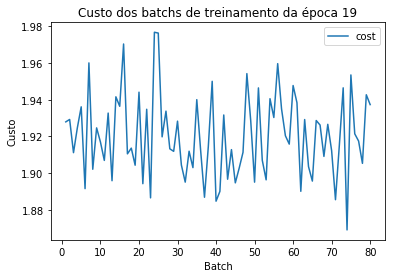

Epoch execution time: 0:00:07.715250
Batch execution time: 0:00:00.084340
Batch execution time: 0:00:00.084748
Batch execution time: 0:00:00.088533
Batch execution time: 0:00:00.087804
Batch execution time: 0:00:00.092015
Batch execution time: 0:00:00.101512
Batch execution time: 0:00:00.118134
Batch execution time: 0:00:00.093442
Batch execution time: 0:00:00.086159
Batch execution time: 0:00:00.082436
Batch execution time: 0:00:00.087015
Batch execution time: 0:00:00.083758
Batch execution time: 0:00:00.081599
Batch execution time: 0:00:00.087455
Batch execution time: 0:00:00.082264
Batch execution time: 0:00:00.082284
Batch execution time: 0:00:00.086849
Batch execution time: 0:00:00.082637
Batch execution time: 0:00:00.081715
Batch execution time: 0:00:00.086948
Batch execution time: 0:00:00.083296
Batch execution time: 0:00:00.082456
Batch execution time: 0:00:00.088716
Batch execution time: 0:00:00.083114
Batch execution time: 0:00:00.082335
Batch execution time: 0:00:00.086663
B

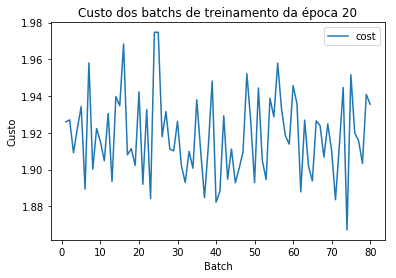

Epoch execution time: 0:00:07.982029
Batch execution time: 0:00:00.083732
Batch execution time: 0:00:00.126749
Batch execution time: 0:00:00.146109
Batch execution time: 0:00:00.158647
Batch execution time: 0:00:00.170166
Batch execution time: 0:00:00.143331
Batch execution time: 0:00:00.162961
Batch execution time: 0:00:00.166486
Batch execution time: 0:00:00.159925
Batch execution time: 0:00:00.207261
Batch execution time: 0:00:00.512186
Batch execution time: 0:00:00.261370
Batch execution time: 0:00:00.135012
Batch execution time: 0:00:00.141181
Batch execution time: 0:00:00.142236
Batch execution time: 0:00:00.152799
Batch execution time: 0:00:00.117095
Batch execution time: 0:00:00.135839
Batch execution time: 0:00:00.126949
Batch execution time: 0:00:00.103947
Batch execution time: 0:00:00.094563
Batch execution time: 0:00:00.124639
Batch execution time: 0:00:00.146115
Batch execution time: 0:00:00.120639
Batch execution time: 0:00:00.100912
Batch execution time: 0:00:00.091704
B

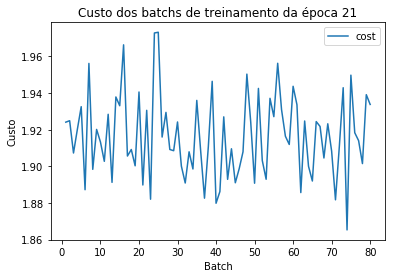

Epoch execution time: 0:00:09.937551
Batch execution time: 0:00:00.085141
Batch execution time: 0:00:00.087156
Batch execution time: 0:00:00.094428
Batch execution time: 0:00:00.086818
Batch execution time: 0:00:00.085686
Batch execution time: 0:00:00.091190
Batch execution time: 0:00:00.082784
Batch execution time: 0:00:00.083148
Batch execution time: 0:00:00.096121
Batch execution time: 0:00:00.085212
Batch execution time: 0:00:00.083882
Batch execution time: 0:00:00.090787
Batch execution time: 0:00:00.085983
Batch execution time: 0:00:00.085310
Batch execution time: 0:00:00.095117
Batch execution time: 0:00:00.083842
Batch execution time: 0:00:00.083226
Batch execution time: 0:00:00.093284
Batch execution time: 0:00:00.086619
Batch execution time: 0:00:00.086045
Batch execution time: 0:00:00.092438
Batch execution time: 0:00:00.084180
Batch execution time: 0:00:00.083851
Batch execution time: 0:00:00.093522
Batch execution time: 0:00:00.086438
Batch execution time: 0:00:00.088822
B

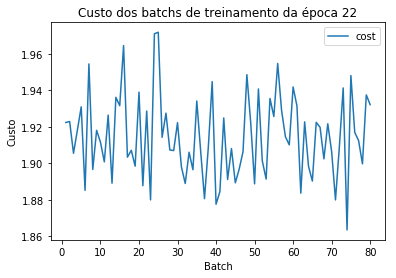

Epoch execution time: 0:00:08.161105
Batch execution time: 0:00:00.084575
Batch execution time: 0:00:00.089351
Batch execution time: 0:00:00.090924
Batch execution time: 0:00:00.083659
Batch execution time: 0:00:00.083532
Batch execution time: 0:00:00.091993
Batch execution time: 0:00:00.087673
Batch execution time: 0:00:00.085230
Batch execution time: 0:00:00.096470
Batch execution time: 0:00:00.089221
Batch execution time: 0:00:00.084349
Batch execution time: 0:00:00.090561
Batch execution time: 0:00:00.087356
Batch execution time: 0:00:00.084658
Batch execution time: 0:00:00.091315
Batch execution time: 0:00:00.086441
Batch execution time: 0:00:00.085211
Batch execution time: 0:00:00.090891
Batch execution time: 0:00:00.090110
Batch execution time: 0:00:00.084446
Batch execution time: 0:00:00.090296
Batch execution time: 0:00:00.085073
Batch execution time: 0:00:00.100823
Batch execution time: 0:00:00.094565
Batch execution time: 0:00:00.084076
Batch execution time: 0:00:00.087292
B

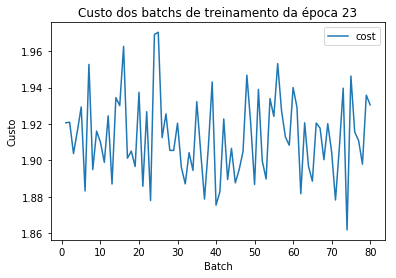

Epoch execution time: 0:00:08.035464
Batch execution time: 0:00:00.089604
Batch execution time: 0:00:00.086348
Batch execution time: 0:00:00.092218
Batch execution time: 0:00:00.084302
Batch execution time: 0:00:00.085011
Batch execution time: 0:00:00.090753
Batch execution time: 0:00:00.091602
Batch execution time: 0:00:00.083951
Batch execution time: 0:00:00.091881
Batch execution time: 0:00:00.085596
Batch execution time: 0:00:00.085125
Batch execution time: 0:00:00.092417
Batch execution time: 0:00:00.084949
Batch execution time: 0:00:00.083915
Batch execution time: 0:00:00.092266
Batch execution time: 0:00:00.085672
Batch execution time: 0:00:00.086232
Batch execution time: 0:00:00.094033
Batch execution time: 0:00:00.082849
Batch execution time: 0:00:00.083281
Batch execution time: 0:00:00.096056
Batch execution time: 0:00:00.086677
Batch execution time: 0:00:00.089373
Batch execution time: 0:00:00.099995
Batch execution time: 0:00:00.089583
Batch execution time: 0:00:00.099020
B

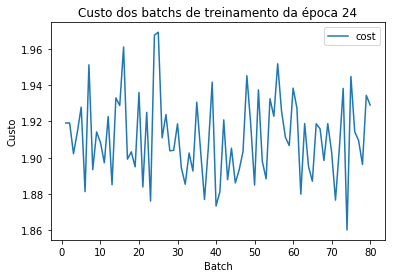

Epoch execution time: 0:00:08.083012
Batch execution time: 0:00:00.084912
Batch execution time: 0:00:00.084778
Batch execution time: 0:00:00.091657
Batch execution time: 0:00:00.086758
Batch execution time: 0:00:00.085217
Batch execution time: 0:00:00.095118
Batch execution time: 0:00:00.095425
Batch execution time: 0:00:00.086798
Batch execution time: 0:00:00.093064
Batch execution time: 0:00:00.086386
Batch execution time: 0:00:00.085651
Batch execution time: 0:00:00.096379
Batch execution time: 0:00:00.088107
Batch execution time: 0:00:00.085262
Batch execution time: 0:00:00.092051
Batch execution time: 0:00:00.084773
Batch execution time: 0:00:00.088575
Batch execution time: 0:00:00.094312
Batch execution time: 0:00:00.085950
Batch execution time: 0:00:00.086671
Batch execution time: 0:00:00.095755
Batch execution time: 0:00:00.087340
Batch execution time: 0:00:00.093330
Batch execution time: 0:00:00.105069
Batch execution time: 0:00:00.086765
Batch execution time: 0:00:00.087333
B

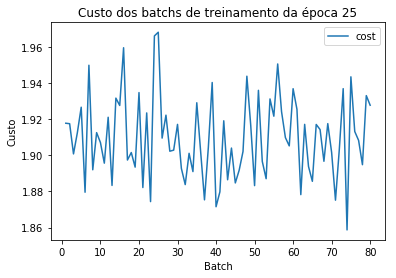

Epoch execution time: 0:00:08.061420
Batch execution time: 0:00:00.086285
Batch execution time: 0:00:00.085794
Batch execution time: 0:00:00.093337
Batch execution time: 0:00:00.086380
Batch execution time: 0:00:00.088741
Batch execution time: 0:00:00.091782
Batch execution time: 0:00:00.083696
Batch execution time: 0:00:00.086883
Batch execution time: 0:00:00.093725
Batch execution time: 0:00:00.086438
Batch execution time: 0:00:00.088126
Batch execution time: 0:00:00.093743
Batch execution time: 0:00:00.085005
Batch execution time: 0:00:00.085023
Batch execution time: 0:00:00.092734
Batch execution time: 0:00:00.087379
Batch execution time: 0:00:00.088043
Batch execution time: 0:00:00.098442
Batch execution time: 0:00:00.086404
Batch execution time: 0:00:00.085032
Batch execution time: 0:00:00.094240
Batch execution time: 0:00:00.090647
Batch execution time: 0:00:00.086377
Batch execution time: 0:00:00.093280
Batch execution time: 0:00:00.086327
Batch execution time: 0:00:00.086653
B

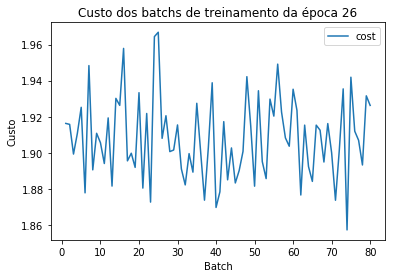

Epoch execution time: 0:00:08.100564
Batch execution time: 0:00:00.084590
Batch execution time: 0:00:00.084085
Batch execution time: 0:00:00.090554
Batch execution time: 0:00:00.088936
Batch execution time: 0:00:00.085940
Batch execution time: 0:00:00.091812
Batch execution time: 0:00:00.085444
Batch execution time: 0:00:00.084596
Batch execution time: 0:00:00.091385
Batch execution time: 0:00:00.088775
Batch execution time: 0:00:00.083556
Batch execution time: 0:00:00.093340
Batch execution time: 0:00:00.085695
Batch execution time: 0:00:00.086033
Batch execution time: 0:00:00.090134
Batch execution time: 0:00:00.086165
Batch execution time: 0:00:00.086470
Batch execution time: 0:00:00.092100
Batch execution time: 0:00:00.086180
Batch execution time: 0:00:00.086603
Batch execution time: 0:00:00.095085
Batch execution time: 0:00:00.083846
Batch execution time: 0:00:00.085619
Batch execution time: 0:00:00.093222
Batch execution time: 0:00:00.085172
Batch execution time: 0:00:00.086183
B

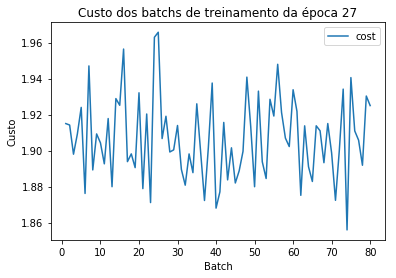

Epoch execution time: 0:00:08.008871
Batch execution time: 0:00:00.085404
Batch execution time: 0:00:00.086185
Batch execution time: 0:00:00.092147
Batch execution time: 0:00:00.086809
Batch execution time: 0:00:00.084857
Batch execution time: 0:00:00.094729
Batch execution time: 0:00:00.084930
Batch execution time: 0:00:00.085634
Batch execution time: 0:00:00.091567
Batch execution time: 0:00:00.085674
Batch execution time: 0:00:00.082989
Batch execution time: 0:00:00.090779
Batch execution time: 0:00:00.085553
Batch execution time: 0:00:00.084842
Batch execution time: 0:00:00.094447
Batch execution time: 0:00:00.085493
Batch execution time: 0:00:00.086009
Batch execution time: 0:00:00.090749
Batch execution time: 0:00:00.083788
Batch execution time: 0:00:00.091055
Batch execution time: 0:00:00.103108
Batch execution time: 0:00:00.087983
Batch execution time: 0:00:00.086339
Batch execution time: 0:00:00.101438
Batch execution time: 0:00:00.083297
Batch execution time: 0:00:00.083575
B

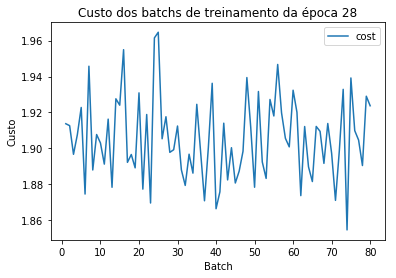

Epoch execution time: 0:00:07.997957
Batch execution time: 0:00:00.084489
Batch execution time: 0:00:00.084534
Batch execution time: 0:00:00.091835
Batch execution time: 0:00:00.088700
Batch execution time: 0:00:00.083952
Batch execution time: 0:00:00.091226
Batch execution time: 0:00:00.084913
Batch execution time: 0:00:00.085936
Batch execution time: 0:00:00.091622
Batch execution time: 0:00:00.089448
Batch execution time: 0:00:00.083799
Batch execution time: 0:00:00.091446
Batch execution time: 0:00:00.086077
Batch execution time: 0:00:00.085890
Batch execution time: 0:00:00.091891
Batch execution time: 0:00:00.085057
Batch execution time: 0:00:00.083776
Batch execution time: 0:00:00.093644
Batch execution time: 0:00:00.089485
Batch execution time: 0:00:00.086595
Batch execution time: 0:00:00.093443
Batch execution time: 0:00:00.082789
Batch execution time: 0:00:00.083190
Batch execution time: 0:00:00.092535
Batch execution time: 0:00:00.084820
Batch execution time: 0:00:00.085853
B

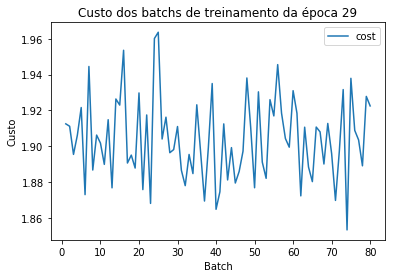

Epoch execution time: 0:00:08.009678
Batch execution time: 0:00:00.084752
Batch execution time: 0:00:00.086679
Batch execution time: 0:00:00.091449
Batch execution time: 0:00:00.088816
Batch execution time: 0:00:00.082369
Batch execution time: 0:00:00.090919
Batch execution time: 0:00:00.086299
Batch execution time: 0:00:00.084449
Batch execution time: 0:00:00.091770
Batch execution time: 0:00:00.089100
Batch execution time: 0:00:00.085016
Batch execution time: 0:00:00.091277
Batch execution time: 0:00:00.086359
Batch execution time: 0:00:00.085971
Batch execution time: 0:00:00.096375
Batch execution time: 0:00:00.083592
Batch execution time: 0:00:00.084650
Batch execution time: 0:00:00.092708
Batch execution time: 0:00:00.084473
Batch execution time: 0:00:00.085335
Batch execution time: 0:00:00.093970
Batch execution time: 0:00:00.084832
Batch execution time: 0:00:00.088863
Batch execution time: 0:00:00.094247
Batch execution time: 0:00:00.084439
Batch execution time: 0:00:00.085636
B

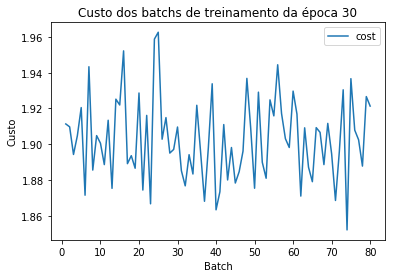

Epoch execution time: 0:00:08.025592
Batch execution time: 0:00:00.086462
Batch execution time: 0:00:00.087134
Batch execution time: 0:00:00.092701
Batch execution time: 0:00:00.089308
Batch execution time: 0:00:00.083595
Batch execution time: 0:00:00.094289
Batch execution time: 0:00:00.085803
Batch execution time: 0:00:00.086287
Batch execution time: 0:00:00.094480
Batch execution time: 0:00:00.084130
Batch execution time: 0:00:00.085371
Batch execution time: 0:00:00.093739
Batch execution time: 0:00:00.087227
Batch execution time: 0:00:00.086039
Batch execution time: 0:00:00.096435
Batch execution time: 0:00:00.085668
Batch execution time: 0:00:00.085742
Batch execution time: 0:00:00.092438
Batch execution time: 0:00:00.088147
Batch execution time: 0:00:00.088334
Batch execution time: 0:00:00.093579
Batch execution time: 0:00:00.086720
Batch execution time: 0:00:00.085766
Batch execution time: 0:00:00.091976
Batch execution time: 0:00:00.085087
Batch execution time: 0:00:00.089365
B

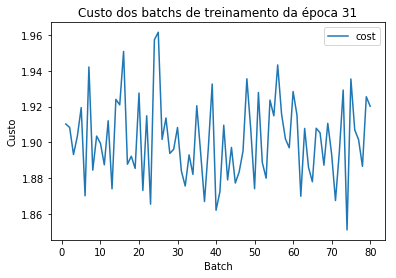

Epoch execution time: 0:00:08.808019
Batch execution time: 0:00:00.116777
Batch execution time: 0:00:00.105449
Batch execution time: 0:00:00.113538
Batch execution time: 0:00:00.091022
Batch execution time: 0:00:00.098633
Batch execution time: 0:00:00.085754
Batch execution time: 0:00:00.091714
Batch execution time: 0:00:00.087907
Batch execution time: 0:00:00.086005
Batch execution time: 0:00:00.111560
Batch execution time: 0:00:00.098535
Batch execution time: 0:00:00.085142
Batch execution time: 0:00:00.093045
Batch execution time: 0:00:00.086080
Batch execution time: 0:00:00.086919
Batch execution time: 0:00:00.104690
Batch execution time: 0:00:00.108577
Batch execution time: 0:00:00.104546
Batch execution time: 0:00:00.101030
Batch execution time: 0:00:00.090610
Batch execution time: 0:00:00.115165
Batch execution time: 0:00:00.107084
Batch execution time: 0:00:00.100483
Batch execution time: 0:00:00.101562
Batch execution time: 0:00:00.114442
Batch execution time: 0:00:00.095463
B

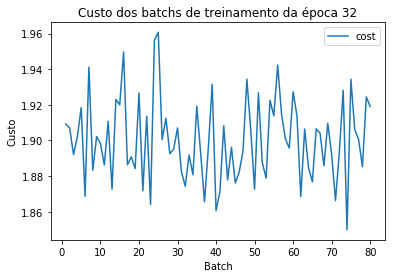

Epoch execution time: 0:00:09.088371
Batch execution time: 0:00:00.087256
Batch execution time: 0:00:00.100934
Batch execution time: 0:00:00.110307
Batch execution time: 0:00:00.092440
Batch execution time: 0:00:00.104591
Batch execution time: 0:00:00.103717
Batch execution time: 0:00:00.084643
Batch execution time: 0:00:00.088511
Batch execution time: 0:00:00.102115
Batch execution time: 0:00:00.087904
Batch execution time: 0:00:00.084076
Batch execution time: 0:00:00.094732
Batch execution time: 0:00:00.090991
Batch execution time: 0:00:00.109537
Batch execution time: 0:00:00.099642
Batch execution time: 0:00:00.086621
Batch execution time: 0:00:00.099491
Batch execution time: 0:00:00.110425
Batch execution time: 0:00:00.103565
Batch execution time: 0:00:00.108839
Batch execution time: 0:00:00.091616
Batch execution time: 0:00:00.182574
Batch execution time: 0:00:00.141277
Batch execution time: 0:00:00.128429
Batch execution time: 0:00:00.108837
Batch execution time: 0:00:00.100654
B

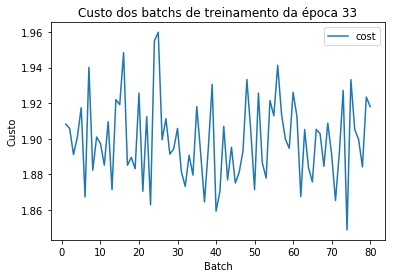

Epoch execution time: 0:00:08.988331
Batch execution time: 0:00:00.085001
Batch execution time: 0:00:00.088078
Batch execution time: 0:00:00.090916
Batch execution time: 0:00:00.084815
Batch execution time: 0:00:00.088220
Batch execution time: 0:00:00.095047
Batch execution time: 0:00:00.087020
Batch execution time: 0:00:00.086476
Batch execution time: 0:00:00.092937
Batch execution time: 0:00:00.092735
Batch execution time: 0:00:00.084999
Batch execution time: 0:00:00.092328
Batch execution time: 0:00:00.088897
Batch execution time: 0:00:00.090882
Batch execution time: 0:00:00.096984
Batch execution time: 0:00:00.108705
Batch execution time: 0:00:00.098633
Batch execution time: 0:00:00.100520
Batch execution time: 0:00:00.109286
Batch execution time: 0:00:00.100100
Batch execution time: 0:00:00.099845
Batch execution time: 0:00:00.096244
Batch execution time: 0:00:00.087893
Batch execution time: 0:00:00.087533
Batch execution time: 0:00:00.091627
Batch execution time: 0:00:00.091039
B

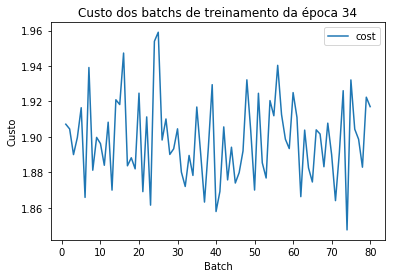

Epoch execution time: 0:00:08.920619
Batch execution time: 0:00:00.106394
Batch execution time: 0:00:00.109216
Batch execution time: 0:00:00.092725
Batch execution time: 0:00:00.087595
Batch execution time: 0:00:00.118504
Batch execution time: 0:00:00.102884
Batch execution time: 0:00:00.103338
Batch execution time: 0:00:00.098006
Batch execution time: 0:00:00.103240
Batch execution time: 0:00:00.116930
Batch execution time: 0:00:00.102580
Batch execution time: 0:00:00.087922
Batch execution time: 0:00:00.112449
Batch execution time: 0:00:00.103252
Batch execution time: 0:00:00.110958
Batch execution time: 0:00:00.112891
Batch execution time: 0:00:00.094383
Batch execution time: 0:00:00.092481
Batch execution time: 0:00:00.094384
Batch execution time: 0:00:00.098856
Batch execution time: 0:00:00.086959
Batch execution time: 0:00:00.098282
Batch execution time: 0:00:00.118446
Batch execution time: 0:00:00.104201
Batch execution time: 0:00:00.105645
Batch execution time: 0:00:00.095176
B

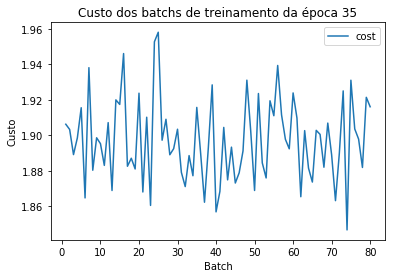

Epoch execution time: 0:00:09.173871
Batch execution time: 0:00:00.109639
Batch execution time: 0:00:00.099771
Batch execution time: 0:00:00.094354
Batch execution time: 0:00:00.087756
Batch execution time: 0:00:00.103109
Batch execution time: 0:00:00.108572
Batch execution time: 0:00:00.090267
Batch execution time: 0:00:00.090969
Batch execution time: 0:00:00.089263
Batch execution time: 0:00:00.105783
Batch execution time: 0:00:00.106118
Batch execution time: 0:00:00.083208
Batch execution time: 0:00:00.086484
Batch execution time: 0:00:00.111759
Batch execution time: 0:00:00.103505
Batch execution time: 0:00:00.105866
Batch execution time: 0:00:00.097959
Batch execution time: 0:00:00.095114
Batch execution time: 0:00:00.115901
Batch execution time: 0:00:00.104417
Batch execution time: 0:00:00.097752
Batch execution time: 0:00:00.094206
Batch execution time: 0:00:00.097921
Batch execution time: 0:00:00.116176
Batch execution time: 0:00:00.111062
Batch execution time: 0:00:00.111085
B

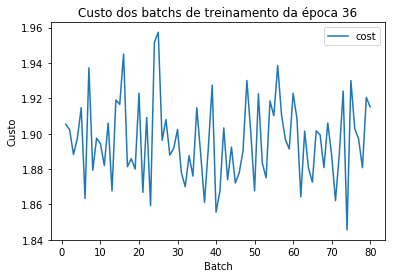

Epoch execution time: 0:00:08.973892
Batch execution time: 0:00:00.112681
Batch execution time: 0:00:00.096754
Batch execution time: 0:00:00.111293
Batch execution time: 0:00:00.110689
Batch execution time: 0:00:00.107315
Batch execution time: 0:00:00.108275
Batch execution time: 0:00:00.103803
Batch execution time: 0:00:00.111956
Batch execution time: 0:00:00.094073
Batch execution time: 0:00:00.106965
Batch execution time: 0:00:00.106683
Batch execution time: 0:00:00.105272
Batch execution time: 0:00:00.106984
Batch execution time: 0:00:00.102730
Batch execution time: 0:00:00.099575
Batch execution time: 0:00:00.108676
Batch execution time: 0:00:00.106043
Batch execution time: 0:00:00.103132
Batch execution time: 0:00:00.102038
Batch execution time: 0:00:00.101296
Batch execution time: 0:00:00.108457
Batch execution time: 0:00:00.103544
Batch execution time: 0:00:00.107074
Batch execution time: 0:00:00.108592
Batch execution time: 0:00:00.106148
Batch execution time: 0:00:00.107919
B

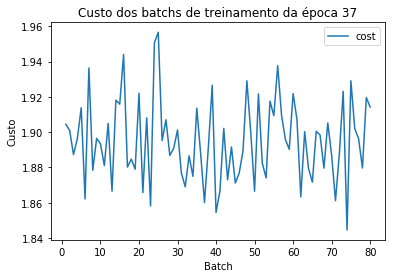

Epoch execution time: 0:00:09.698214
Batch execution time: 0:00:00.103691
Batch execution time: 0:00:00.111611
Batch execution time: 0:00:00.108761
Batch execution time: 0:00:00.091825
Batch execution time: 0:00:00.116966
Batch execution time: 0:00:00.108891
Batch execution time: 0:00:00.102189
Batch execution time: 0:00:00.094501
Batch execution time: 0:00:00.087396
Batch execution time: 0:00:00.115041
Batch execution time: 0:00:00.107752
Batch execution time: 0:00:00.099706
Batch execution time: 0:00:00.115082
Batch execution time: 0:00:00.103992
Batch execution time: 0:00:00.110366
Batch execution time: 0:00:00.114608
Batch execution time: 0:00:00.114843
Batch execution time: 0:00:00.087937
Batch execution time: 0:00:00.097170
Batch execution time: 0:00:00.087233
Batch execution time: 0:00:00.098047
Batch execution time: 0:00:00.095889
Batch execution time: 0:00:00.102866
Batch execution time: 0:00:00.104998
Batch execution time: 0:00:00.107164
Batch execution time: 0:00:00.100871
B

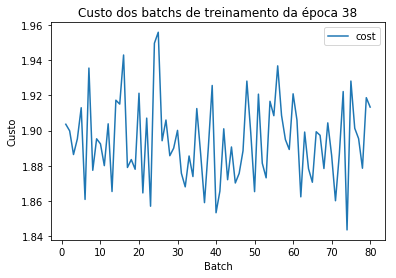

Epoch execution time: 0:00:09.398762
Batch execution time: 0:00:00.090281
Batch execution time: 0:00:00.127907
Batch execution time: 0:00:00.113433
Batch execution time: 0:00:00.116987
Batch execution time: 0:00:00.100352
Batch execution time: 0:00:00.115896
Batch execution time: 0:00:00.097749
Batch execution time: 0:00:00.086584
Batch execution time: 0:00:00.093769
Batch execution time: 0:00:00.083752
Batch execution time: 0:00:00.085009
Batch execution time: 0:00:00.096832
Batch execution time: 0:00:00.103014
Batch execution time: 0:00:00.105139
Batch execution time: 0:00:00.100869
Batch execution time: 0:00:00.123205
Batch execution time: 0:00:00.131287
Batch execution time: 0:00:00.084209
Batch execution time: 0:00:00.093087
Batch execution time: 0:00:00.089590
Batch execution time: 0:00:00.131662
Batch execution time: 0:00:00.131800
Batch execution time: 0:00:00.120267
Batch execution time: 0:00:00.097089
Batch execution time: 0:00:00.119781
Batch execution time: 0:00:00.124846
B

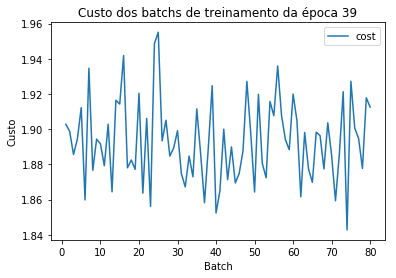

Epoch execution time: 0:00:09.802536
Batch execution time: 0:00:00.086739
Batch execution time: 0:00:00.087248
Batch execution time: 0:00:00.092275
Batch execution time: 0:00:00.085398
Batch execution time: 0:00:00.089639
Batch execution time: 0:00:00.103787
Batch execution time: 0:00:00.113423
Batch execution time: 0:00:00.107822
Batch execution time: 0:00:00.119797
Batch execution time: 0:00:00.130909
Batch execution time: 0:00:00.093784
Batch execution time: 0:00:00.085880
Batch execution time: 0:00:00.094062
Batch execution time: 0:00:00.088029
Batch execution time: 0:00:00.097647
Batch execution time: 0:00:00.101903
Batch execution time: 0:00:00.101498
Batch execution time: 0:00:00.098823
Batch execution time: 0:00:00.088617
Batch execution time: 0:00:00.088740
Batch execution time: 0:00:00.084388
Batch execution time: 0:00:00.090138
Batch execution time: 0:00:00.087150
Batch execution time: 0:00:00.095427
Batch execution time: 0:00:00.126097
Batch execution time: 0:00:00.110173
B

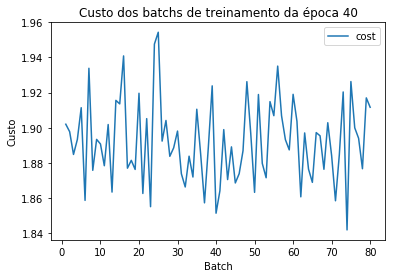

Epoch execution time: 0:00:08.727651
Batch execution time: 0:00:00.101651
Batch execution time: 0:00:00.100953
Batch execution time: 0:00:00.102912
Batch execution time: 0:00:00.091828
Batch execution time: 0:00:00.106523
Batch execution time: 0:00:00.107632
Batch execution time: 0:00:00.103105
Batch execution time: 0:00:00.095795
Batch execution time: 0:00:00.099172
Batch execution time: 0:00:00.103646
Batch execution time: 0:00:00.100617
Batch execution time: 0:00:00.105913
Batch execution time: 0:00:00.097377
Batch execution time: 0:00:00.092417
Batch execution time: 0:00:00.109599
Batch execution time: 0:00:00.100598
Batch execution time: 0:00:00.097644
Batch execution time: 0:00:00.085830
Batch execution time: 0:00:00.098281
Batch execution time: 0:00:00.090965
Batch execution time: 0:00:00.085335
Batch execution time: 0:00:00.098558
Batch execution time: 0:00:00.089391
Batch execution time: 0:00:00.086947
Batch execution time: 0:00:00.100400
Batch execution time: 0:00:00.106095
B

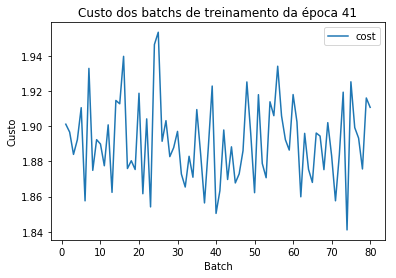

Epoch execution time: 0:00:08.700661
Batch execution time: 0:00:00.085249
Batch execution time: 0:00:00.086426
Batch execution time: 0:00:00.091764
Batch execution time: 0:00:00.087952
Batch execution time: 0:00:00.087216
Batch execution time: 0:00:00.093837
Batch execution time: 0:00:00.085763
Batch execution time: 0:00:00.084361
Batch execution time: 0:00:00.091489
Batch execution time: 0:00:00.086751
Batch execution time: 0:00:00.087253
Batch execution time: 0:00:00.096286
Batch execution time: 0:00:00.086832
Batch execution time: 0:00:00.085457
Batch execution time: 0:00:00.092193
Batch execution time: 0:00:00.086329
Batch execution time: 0:00:00.088241
Batch execution time: 0:00:00.092815
Batch execution time: 0:00:00.085540
Batch execution time: 0:00:00.086600
Batch execution time: 0:00:00.094795
Batch execution time: 0:00:00.084933
Batch execution time: 0:00:00.089590
Batch execution time: 0:00:00.091686
Batch execution time: 0:00:00.086471
Batch execution time: 0:00:00.085456
B

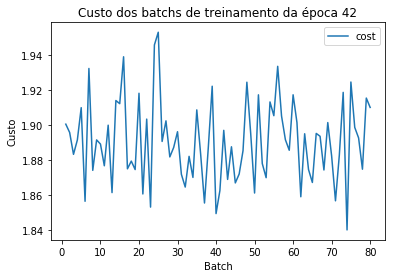

Epoch execution time: 0:00:08.521145
Batch execution time: 0:00:00.102129
Batch execution time: 0:00:00.104070
Batch execution time: 0:00:00.106398
Batch execution time: 0:00:00.091488
Batch execution time: 0:00:00.102957
Batch execution time: 0:00:00.089329
Batch execution time: 0:00:00.085931
Batch execution time: 0:00:00.094290
Batch execution time: 0:00:00.089443
Batch execution time: 0:00:00.090348
Batch execution time: 0:00:00.098870
Batch execution time: 0:00:00.091387
Batch execution time: 0:00:00.105576
Batch execution time: 0:00:00.105389
Batch execution time: 0:00:00.098585
Batch execution time: 0:00:00.106939
Batch execution time: 0:00:00.111134
Batch execution time: 0:00:00.093940
Batch execution time: 0:00:00.095100
Batch execution time: 0:00:00.087468
Batch execution time: 0:00:00.096992
Batch execution time: 0:00:00.108815
Batch execution time: 0:00:00.095609
Batch execution time: 0:00:00.095299
Batch execution time: 0:00:00.087437
Batch execution time: 0:00:00.113048
B

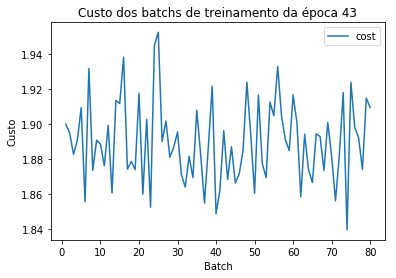

Epoch execution time: 0:00:09.195755
Batch execution time: 0:00:00.083623
Batch execution time: 0:00:00.086614
Batch execution time: 0:00:00.104804
Batch execution time: 0:00:00.124816
Batch execution time: 0:00:00.108410
Batch execution time: 0:00:00.118100
Batch execution time: 0:00:00.118288
Batch execution time: 0:00:00.103786
Batch execution time: 0:00:00.094321
Batch execution time: 0:00:00.115084
Batch execution time: 0:00:00.110199
Batch execution time: 0:00:00.126384
Batch execution time: 0:00:00.103774
Batch execution time: 0:00:00.087013
Batch execution time: 0:00:00.098180
Batch execution time: 0:00:00.093535
Batch execution time: 0:00:00.096760
Batch execution time: 0:00:00.097558
Batch execution time: 0:00:00.087165
Batch execution time: 0:00:00.086839
Batch execution time: 0:00:00.093740
Batch execution time: 0:00:00.089160
Batch execution time: 0:00:00.105335
Batch execution time: 0:00:00.103050
Batch execution time: 0:00:00.107704
Batch execution time: 0:00:00.096270
B

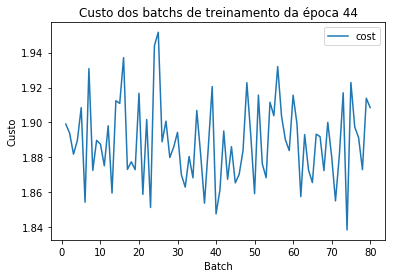

Epoch execution time: 0:00:09.109984
Batch execution time: 0:00:00.117442
Batch execution time: 0:00:00.088660
Batch execution time: 0:00:00.099555
Batch execution time: 0:00:00.115879
Batch execution time: 0:00:00.099684
Batch execution time: 0:00:00.084139
Batch execution time: 0:00:00.093680
Batch execution time: 0:00:00.085411
Batch execution time: 0:00:00.088259
Batch execution time: 0:00:00.092177
Batch execution time: 0:00:00.099507
Batch execution time: 0:00:00.103864
Batch execution time: 0:00:00.097339
Batch execution time: 0:00:00.082769
Batch execution time: 0:00:00.090318
Batch execution time: 0:00:00.085917
Batch execution time: 0:00:00.083530
Batch execution time: 0:00:00.093136
Batch execution time: 0:00:00.083196
Batch execution time: 0:00:00.087401
Batch execution time: 0:00:00.092015
Batch execution time: 0:00:00.087592
Batch execution time: 0:00:00.091197
Batch execution time: 0:00:00.091539
Batch execution time: 0:00:00.084584
Batch execution time: 0:00:00.085711
B

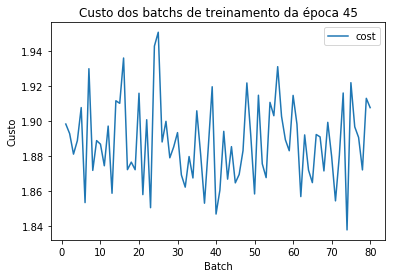

Epoch execution time: 0:00:08.118591
Batch execution time: 0:00:00.088818
Batch execution time: 0:00:00.086324
Batch execution time: 0:00:00.093388
Batch execution time: 0:00:00.088372
Batch execution time: 0:00:00.086832
Batch execution time: 0:00:00.092221
Batch execution time: 0:00:00.086974
Batch execution time: 0:00:00.084007
Batch execution time: 0:00:00.092418
Batch execution time: 0:00:00.085737
Batch execution time: 0:00:00.086765
Batch execution time: 0:00:00.094068
Batch execution time: 0:00:00.082787
Batch execution time: 0:00:00.085644
Batch execution time: 0:00:00.093386
Batch execution time: 0:00:00.086178
Batch execution time: 0:00:00.085664
Batch execution time: 0:00:00.102248
Batch execution time: 0:00:00.083188
Batch execution time: 0:00:00.087494
Batch execution time: 0:00:00.092580
Batch execution time: 0:00:00.085406
Batch execution time: 0:00:00.085973
Batch execution time: 0:00:00.094748
Batch execution time: 0:00:00.083147
Batch execution time: 0:00:00.085502
B

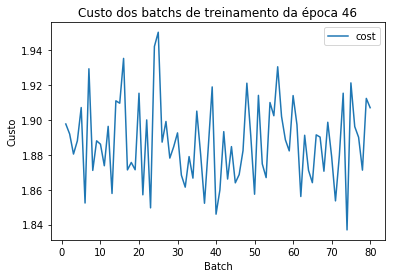

Epoch execution time: 0:00:08.182286
Batch execution time: 0:00:00.084780
Batch execution time: 0:00:00.084959
Batch execution time: 0:00:00.091416
Batch execution time: 0:00:00.087664
Batch execution time: 0:00:00.105638
Batch execution time: 0:00:00.092101
Batch execution time: 0:00:00.084828
Batch execution time: 0:00:00.086485
Batch execution time: 0:00:00.093302
Batch execution time: 0:00:00.090606
Batch execution time: 0:00:00.084300
Batch execution time: 0:00:00.092358
Batch execution time: 0:00:00.087148
Batch execution time: 0:00:00.083718
Batch execution time: 0:00:00.092006
Batch execution time: 0:00:00.087746
Batch execution time: 0:00:00.082322
Batch execution time: 0:00:00.093349
Batch execution time: 0:00:00.091725
Batch execution time: 0:00:00.085685
Batch execution time: 0:00:00.096583
Batch execution time: 0:00:00.083289
Batch execution time: 0:00:00.082621
Batch execution time: 0:00:00.091816
Batch execution time: 0:00:00.085602
Batch execution time: 0:00:00.084411
B

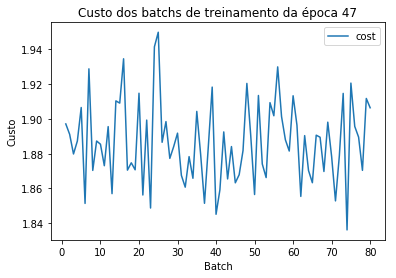

Epoch execution time: 0:00:08.269754
Batch execution time: 0:00:00.107090
Batch execution time: 0:00:00.105708
Batch execution time: 0:00:00.114687
Batch execution time: 0:00:00.121635
Batch execution time: 0:00:00.124112
Batch execution time: 0:00:00.097402
Batch execution time: 0:00:00.091294
Batch execution time: 0:00:00.087357
Batch execution time: 0:00:00.113011
Batch execution time: 0:00:00.102790
Batch execution time: 0:00:00.111439
Batch execution time: 0:00:00.106216
Batch execution time: 0:00:00.097020
Batch execution time: 0:00:00.115451
Batch execution time: 0:00:00.111109
Batch execution time: 0:00:00.104223
Batch execution time: 0:00:00.104201
Batch execution time: 0:00:00.089169
Batch execution time: 0:00:00.111007
Batch execution time: 0:00:00.107892
Batch execution time: 0:00:00.105597
Batch execution time: 0:00:00.105983
Batch execution time: 0:00:00.095916
Batch execution time: 0:00:00.107319
Batch execution time: 0:00:00.107443
Batch execution time: 0:00:00.104544
B

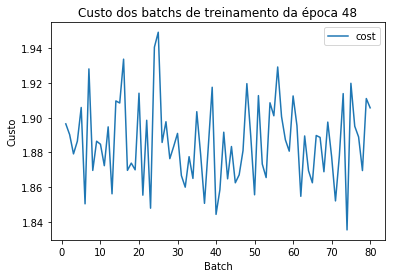

Epoch execution time: 0:00:09.244210
Batch execution time: 0:00:00.107821
Batch execution time: 0:00:00.097193
Batch execution time: 0:00:00.105849
Batch execution time: 0:00:00.114024
Batch execution time: 0:00:00.106740
Batch execution time: 0:00:00.103700
Batch execution time: 0:00:00.094464
Batch execution time: 0:00:00.086005
Batch execution time: 0:00:00.115053
Batch execution time: 0:00:00.115539
Batch execution time: 0:00:00.103688
Batch execution time: 0:00:00.094072
Batch execution time: 0:00:00.085614
Batch execution time: 0:00:00.109615
Batch execution time: 0:00:00.112684
Batch execution time: 0:00:00.107376
Batch execution time: 0:00:00.103020
Batch execution time: 0:00:00.097326
Batch execution time: 0:00:00.134772
Batch execution time: 0:00:00.127577
Batch execution time: 0:00:00.115289
Batch execution time: 0:00:00.097512
Batch execution time: 0:00:00.102933
Batch execution time: 0:00:00.095660
Batch execution time: 0:00:00.099589
Batch execution time: 0:00:00.093082
B

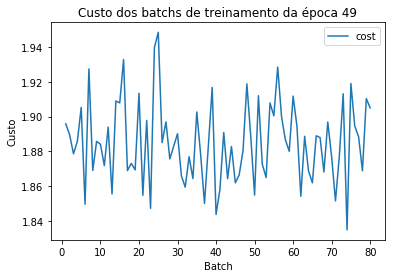

Epoch execution time: 0:00:09.190942
Batch execution time: 0:00:00.107232
Batch execution time: 0:00:00.109752
Batch execution time: 0:00:00.106063
Batch execution time: 0:00:00.090215
Batch execution time: 0:00:00.104316
Batch execution time: 0:00:00.107676
Batch execution time: 0:00:00.099331
Batch execution time: 0:00:00.091016
Batch execution time: 0:00:00.086115
Batch execution time: 0:00:00.099801
Batch execution time: 0:00:00.111820
Batch execution time: 0:00:00.109284
Batch execution time: 0:00:00.103062
Batch execution time: 0:00:00.095181
Batch execution time: 0:00:00.105501
Batch execution time: 0:00:00.087383
Batch execution time: 0:00:00.089396
Batch execution time: 0:00:00.098305
Batch execution time: 0:00:00.103024
Batch execution time: 0:00:00.087994
Batch execution time: 0:00:00.092368
Batch execution time: 0:00:00.092587
Batch execution time: 0:00:00.087969
Batch execution time: 0:00:00.097053
Batch execution time: 0:00:00.100241
Batch execution time: 0:00:00.111101
B

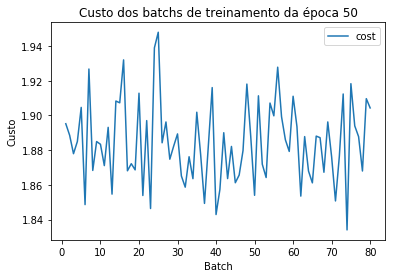

Epoch execution time: 0:00:08.366831
Batch execution time: 0:00:00.085446
Batch execution time: 0:00:00.087959
Batch execution time: 0:00:00.091510
Batch execution time: 0:00:00.088129
Batch execution time: 0:00:00.085062
Batch execution time: 0:00:00.094176
Batch execution time: 0:00:00.084009
Batch execution time: 0:00:00.085652
Batch execution time: 0:00:00.095370
Batch execution time: 0:00:00.087859
Batch execution time: 0:00:00.086996
Batch execution time: 0:00:00.092634
Batch execution time: 0:00:00.085318
Batch execution time: 0:00:00.085340
Batch execution time: 0:00:00.091827
Batch execution time: 0:00:00.084447
Batch execution time: 0:00:00.083974
Batch execution time: 0:00:00.092551
Batch execution time: 0:00:00.085323
Batch execution time: 0:00:00.085668
Batch execution time: 0:00:00.094267
Batch execution time: 0:00:00.086667
Batch execution time: 0:00:00.085786
Batch execution time: 0:00:00.091832
Batch execution time: 0:00:00.085488
Batch execution time: 0:00:00.088355
B

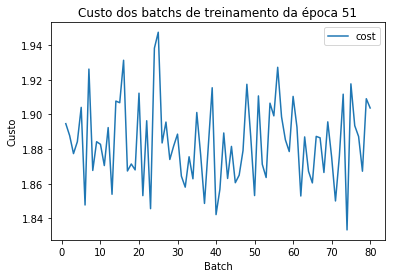

Epoch execution time: 0:00:08.056580
Batch execution time: 0:00:00.085930
Batch execution time: 0:00:00.084699
Batch execution time: 0:00:00.095901
Batch execution time: 0:00:00.082845
Batch execution time: 0:00:00.084374
Batch execution time: 0:00:00.091839
Batch execution time: 0:00:00.083271
Batch execution time: 0:00:00.084807
Batch execution time: 0:00:00.094442
Batch execution time: 0:00:00.085346
Batch execution time: 0:00:00.084133
Batch execution time: 0:00:00.090812
Batch execution time: 0:00:00.094413
Batch execution time: 0:00:00.103252
Batch execution time: 0:00:00.101576
Batch execution time: 0:00:00.085226
Batch execution time: 0:00:00.102944
Batch execution time: 0:00:00.119156
Batch execution time: 0:00:00.113322
Batch execution time: 0:00:00.124942
Batch execution time: 0:00:00.107419
Batch execution time: 0:00:00.110858
Batch execution time: 0:00:00.111169
Batch execution time: 0:00:00.109719
Batch execution time: 0:00:00.113439
Batch execution time: 0:00:00.104210
B

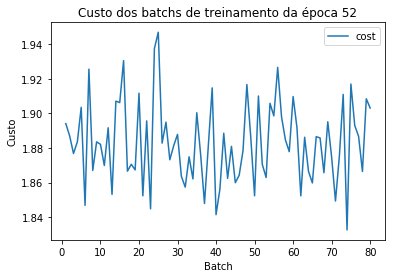

Epoch execution time: 0:00:08.951683
Batch execution time: 0:00:00.111896
Batch execution time: 0:00:00.088382
Batch execution time: 0:00:00.095476
Batch execution time: 0:00:00.086653
Batch execution time: 0:00:00.086067
Batch execution time: 0:00:00.096134
Batch execution time: 0:00:00.101738
Batch execution time: 0:00:00.111247
Batch execution time: 0:00:00.106243
Batch execution time: 0:00:00.082183
Batch execution time: 0:00:00.090090
Batch execution time: 0:00:00.085101
Batch execution time: 0:00:00.084887
Batch execution time: 0:00:00.095211
Batch execution time: 0:00:00.084654
Batch execution time: 0:00:00.088075
Batch execution time: 0:00:00.107101
Batch execution time: 0:00:00.087301
Batch execution time: 0:00:00.083080
Batch execution time: 0:00:00.098355
Batch execution time: 0:00:00.107456
Batch execution time: 0:00:00.104467
Batch execution time: 0:00:00.106691
Batch execution time: 0:00:00.107917
Batch execution time: 0:00:00.103407
Batch execution time: 0:00:00.100284
B

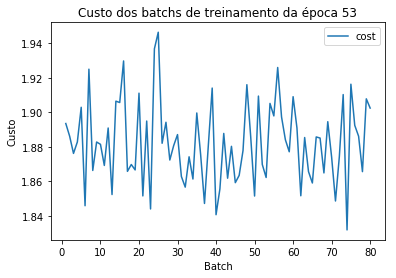

Epoch execution time: 0:00:08.819274
Batch execution time: 0:00:00.090858
Batch execution time: 0:00:00.093341
Batch execution time: 0:00:00.103189
Batch execution time: 0:00:00.085091
Batch execution time: 0:00:00.084365
Batch execution time: 0:00:00.103363
Batch execution time: 0:00:00.126476
Batch execution time: 0:00:00.121757
Batch execution time: 0:00:00.115949
Batch execution time: 0:00:00.093464
Batch execution time: 0:00:00.137460
Batch execution time: 0:00:00.186918
Batch execution time: 0:00:00.116166
Batch execution time: 0:00:00.086589
Batch execution time: 0:00:00.085654
Batch execution time: 0:00:00.086925
Batch execution time: 0:00:00.087093
Batch execution time: 0:00:00.087298
Batch execution time: 0:00:00.089421
Batch execution time: 0:00:00.085462
Batch execution time: 0:00:00.087054
Batch execution time: 0:00:00.086303
Batch execution time: 0:00:00.086938
Batch execution time: 0:00:00.087009
Batch execution time: 0:00:00.089202
Batch execution time: 0:00:00.082341
B

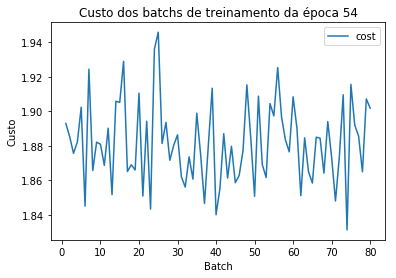

Epoch execution time: 0:00:09.042244
Batch execution time: 0:00:00.083819
Batch execution time: 0:00:00.083873
Batch execution time: 0:00:00.093852
Batch execution time: 0:00:00.087833
Batch execution time: 0:00:00.086735
Batch execution time: 0:00:00.093711
Batch execution time: 0:00:00.094785
Batch execution time: 0:00:00.110947
Batch execution time: 0:00:00.106930
Batch execution time: 0:00:00.108376
Batch execution time: 0:00:00.104065
Batch execution time: 0:00:00.094331
Batch execution time: 0:00:00.100747
Batch execution time: 0:00:00.102687
Batch execution time: 0:00:00.103843
Batch execution time: 0:00:00.103567
Batch execution time: 0:00:00.101990
Batch execution time: 0:00:00.108631
Batch execution time: 0:00:00.102693
Batch execution time: 0:00:00.110450
Batch execution time: 0:00:00.091171
Batch execution time: 0:00:00.110141
Batch execution time: 0:00:00.114331
Batch execution time: 0:00:00.099883
Batch execution time: 0:00:00.088415
Batch execution time: 0:00:00.097297
B

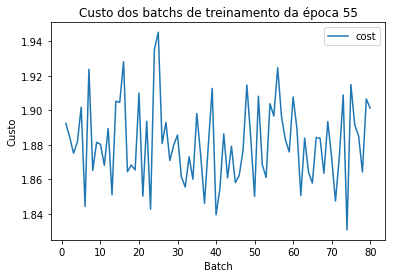

Epoch execution time: 0:00:09.088863
Batch execution time: 0:00:00.085964
Batch execution time: 0:00:00.083839
Batch execution time: 0:00:00.092832
Batch execution time: 0:00:00.089426
Batch execution time: 0:00:00.086727
Batch execution time: 0:00:00.091272
Batch execution time: 0:00:00.083850
Batch execution time: 0:00:00.085297
Batch execution time: 0:00:00.091318
Batch execution time: 0:00:00.093336
Batch execution time: 0:00:00.084398
Batch execution time: 0:00:00.093173
Batch execution time: 0:00:00.087591
Batch execution time: 0:00:00.094499
Batch execution time: 0:00:00.122789
Batch execution time: 0:00:00.103190
Batch execution time: 0:00:00.106140
Batch execution time: 0:00:00.108832
Batch execution time: 0:00:00.096128
Batch execution time: 0:00:00.111370
Batch execution time: 0:00:00.109141
Batch execution time: 0:00:00.101696
Batch execution time: 0:00:00.100732
Batch execution time: 0:00:00.105147
Batch execution time: 0:00:00.100382
Batch execution time: 0:00:00.099438
B

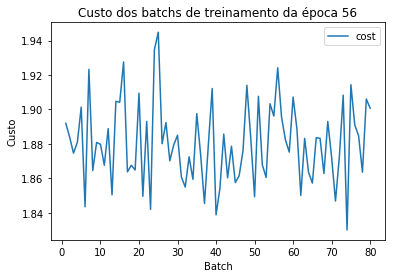

Epoch execution time: 0:00:08.931229
Batch execution time: 0:00:00.099086
Batch execution time: 0:00:00.086809
Batch execution time: 0:00:00.092701
Batch execution time: 0:00:00.086820
Batch execution time: 0:00:00.090023
Batch execution time: 0:00:00.093036
Batch execution time: 0:00:00.086520
Batch execution time: 0:00:00.084973
Batch execution time: 0:00:00.094182
Batch execution time: 0:00:00.088488
Batch execution time: 0:00:00.085813
Batch execution time: 0:00:00.093654
Batch execution time: 0:00:00.082948
Batch execution time: 0:00:00.085529
Batch execution time: 0:00:00.094607
Batch execution time: 0:00:00.090151
Batch execution time: 0:00:00.086276
Batch execution time: 0:00:00.094336
Batch execution time: 0:00:00.084470
Batch execution time: 0:00:00.084088
Batch execution time: 0:00:00.094601
Batch execution time: 0:00:00.087794
Batch execution time: 0:00:00.085399
Batch execution time: 0:00:00.094135
Batch execution time: 0:00:00.087411
Batch execution time: 0:00:00.087678
B

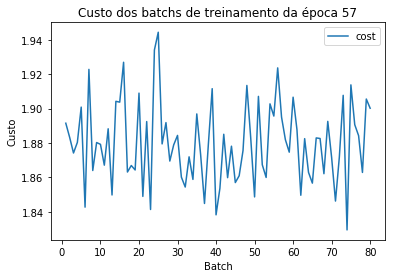

Epoch execution time: 0:00:08.463976
Batch execution time: 0:00:00.116365
Batch execution time: 0:00:00.095392
Batch execution time: 0:00:00.094212
Batch execution time: 0:00:00.094462
Batch execution time: 0:00:00.119831
Batch execution time: 0:00:00.087958
Batch execution time: 0:00:00.089433
Batch execution time: 0:00:00.103836
Batch execution time: 0:00:00.101714
Batch execution time: 0:00:00.091127
Batch execution time: 0:00:00.092203
Batch execution time: 0:00:00.089877
Batch execution time: 0:00:00.100141
Batch execution time: 0:00:00.099496
Batch execution time: 0:00:00.094917
Batch execution time: 0:00:00.105470
Batch execution time: 0:00:00.124446
Batch execution time: 0:00:00.105008
Batch execution time: 0:00:00.107753
Batch execution time: 0:00:00.105138
Batch execution time: 0:00:00.095944
Batch execution time: 0:00:00.110362
Batch execution time: 0:00:00.108495
Batch execution time: 0:00:00.113475
Batch execution time: 0:00:00.099827
Batch execution time: 0:00:00.117837
B

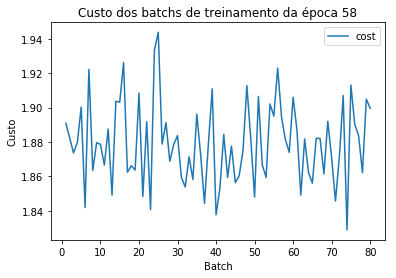

Epoch execution time: 0:00:09.391392
Batch execution time: 0:00:00.110595
Batch execution time: 0:00:00.101742
Batch execution time: 0:00:00.104758
Batch execution time: 0:00:00.093352
Batch execution time: 0:00:00.103358
Batch execution time: 0:00:00.116184
Batch execution time: 0:00:00.104182
Batch execution time: 0:00:00.108516
Batch execution time: 0:00:00.100942
Batch execution time: 0:00:00.111340
Batch execution time: 0:00:00.092644
Batch execution time: 0:00:00.112990
Batch execution time: 0:00:00.091469
Batch execution time: 0:00:00.090593
Batch execution time: 0:00:00.086829
Batch execution time: 0:00:00.114670
Batch execution time: 0:00:00.102032
Batch execution time: 0:00:00.092510
Batch execution time: 0:00:00.096411
Batch execution time: 0:00:00.089475
Batch execution time: 0:00:00.090285
Batch execution time: 0:00:00.093581
Batch execution time: 0:00:00.098619
Batch execution time: 0:00:00.091254
Batch execution time: 0:00:00.095649
Batch execution time: 0:00:00.091559
B

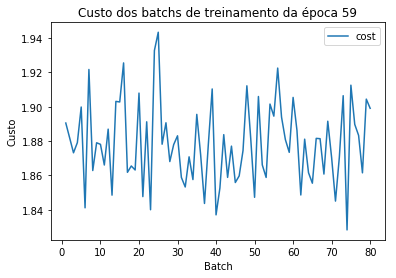

Epoch execution time: 0:00:08.946899
Cost by Epoch: [(0, 2.1236734943277953, 2.127274131057867), (1, 2.061456004733135, 2.063054941776913), (2, 2.0307716799922435, 2.029017426868786), (3, 2.0119541129754883, 2.0072831606497137), (4, 1.9989675085571033, 1.9920173444829696), (5, 1.9892716336798804, 1.9805873028096634), (6, 1.9816151966269817, 1.971621596432542), (7, 1.9753167529540383, 1.964339266099306), (8, 1.9699763244303998, 1.9582644160120593), (9, 1.9653443835209194, 1.9530904259718342), (10, 1.9612569621026827, 1.9486102450769809), (11, 1.957601339505249, 1.9446783904347347), (12, 1.9542969148802884, 1.9411891454541121), (13, 1.9512840535313287, 1.9380634793117049), (14, 1.948517319147588, 1.9352408796108571), (15, 1.9459612165953484, 1.9326740670381004), (16, 1.9435874236566681, 1.9303254632349522), (17, 1.9413729347429758, 1.9281647610809858), (18, 1.9392987800645272, 1.9261672094217233), (19, 1.9373491181506104, 1.9243123737863246), (20, 1.9355105770194774, 1.9225832223561068),

In [111]:
(cost_by_epoch_training, weightsLinearRegression)= train(60,weights1,0.01,1000,inputs,-1)

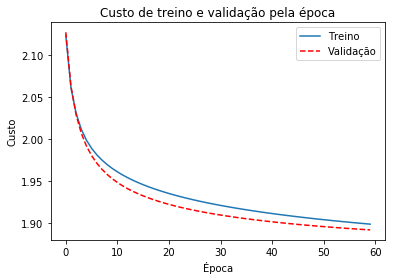

In [112]:
plot_cost_train_val_by_epoch(cost_by_epoch_training)

# Redes Neurais

In [113]:
def relu(x):
    if x < 0:
        return 0
    else:
        return x

In [114]:
def reluMatrix(ZnetHidden): 
    vectRelu = np.vectorize(relu)
    ZOutHidden = vectRelu(ZnetHidden)
        
    return ZOutHidden

In [115]:
def addBiasHidden(ZOutHidden):
    ZOutBias = []
    
    for (i,I) in enumerate(ZOutHidden):
        linha = [1] + I
        ZOutBias.append(linha)
        
    return ZOutBias

## Forward Propagation

In [116]:
def processFoward(inputs, weights1, weights2):
    #Camada escondida - hidden
    ZnetHidden = calculateZNet(inputs, weights1)
    ZOutHidden = reluMatrix(ZnetHidden)
#     ZOutHidden = addBiasHidden(ZOutHidden)
    
    #Camada final - out
    inputs2 = np.array(ZOutHidden)
    ZNetOut = calculateZNet(inputs2, weights2)
    ZOutAll = softmax(ZNetOut)
    
    return (ZnetHidden, ZOutHidden, ZNetOut, ZOutAll)

## BackPropagation

In [117]:
def derivativeCostFunctionFistLayer(weights1, Zout, targets, weights2, ZnetHidden, inputs):
    Out = np.subtract(Zout, targets)
    dETotal_dOuth = Out.dot(weights2.T)
    
    derivative_relu = lambda x : 1 if x > 0 else 0
    derivative_relu_vec = np.vectorize(derivative_relu)
    
    dOuth1_dNeth1 = derivative_relu_vec(ZnetHidden)
    
    aux = dOuth1_dNeth1 * dETotal_dOuth
    
    dETotal_dW = inputs.T.dot(aux)
    
    qtdLinhas = len(inputs)
    
    divide = lambda x : x / qtdLinhas
    
    ajuste_weight = divide(dETotal_dW)
    
    return ajuste_weight

In [118]:
def backpropagation(inputs,ZNetHiddenP,ZOutHidden,ZOutAll,weightsInHiddenConnection,weightsHiddenOutConnection,targets,learningRate):
    variationWeightInHidden = derivativeCostFunctionFistLayer(weightsInHiddenConnection, ZOutAll, targets, weightsHiddenOutConnection, ZNetHiddenP, inputs)
    variationWeightHiddenOut = derivativeCostFunction(ZOutHidden, ZOutAll, targets, weightsHiddenOutConnection)
    
    #Atualizando pesos da conexão in - hidden
    v1 = learningRate*variationWeightInHidden
    updatedWeightsInHidden = np.subtract(weightsInHiddenConnection, v1)
    
    v2 = learningRate*variationWeightHiddenOut
    updatedWeightsHiddenOut = np.subtract(weightsHiddenOutConnection,v2)
    
    return (updatedWeightsInHidden, updatedWeightsHiddenOut)

### Treino

In [125]:
def train_neural_network(epochs,weightsInHiddenConnection,weightsHiddenOutConnection,learningRate,batchSize,dataSet,batchIterations):        
    cost_by_epoch = list()

    for i in range(epochs):
        epochInitTime = datetime.datetime.now()
        iterator = BatchIterator(batchSize, dataSet,batchIterations)
        targetIterator = BatchIterator(batchSize, targets, batchIterations)

        bestCost = -1;
        cost_by_batch = list()
        batchIndex = 0

        while iterator.hasNext():
            initTime = datetime.datetime.now()

            batch = iterator.prox()
            batchTargets = targetIterator.prox()

            (ZnetHidden, ZOutHidden, Znet, ZOut) = processFoward(batch,weightsInHiddenConnection,weightsHiddenOutConnection)

            (updatedWeightsInHidden, updatedWeightsHiddenOut) = backpropagation(batch,ZnetHidden,ZOutHidden,ZOut,weightsInHiddenConnection,weightsHiddenOutConnection,batchTargets,learningRate)
            
            weightsInHiddenConnection = updatedWeightsInHidden
            weightsHiddenOutConnection = updatedWeightsHiddenOut
            
            cost = costFunction(ZOut, targets)

            batchIndex+=1
            cost_by_batch.append((batchIndex, cost))

#             if(bestCost == -1 or cost < bestCost):
            bestCost = cost
#                 weightsInHiddenConnection = updatedWeightsInHidden
#                 weightsHiddenOutConnection = updatedWeightsHiddenOut

            endTime = datetime.datetime.now()

            print("Batch execution time:", endTime - initTime)

        print("cost_by_batch:", cost_by_batch)
        #Plota os custos por batch da época
        df_cost_batch = pd.DataFrame(cost_by_batch, columns = ['batch' , 'cost',])
        fig, ax = plt.subplots()
        plt.title("Custo dos batchs de treinamento da época " + str(i))
        plt.xlabel('Batch')
        plt.ylabel('Custo')
        ax.plot(df_cost_batch['batch'], df_cost_batch['cost'])
        ax.legend()
        plt.show()

        # Validação
        (ZnetHiddenVal, ZOutHiddenVal, ZnetVal, ZOutVal) = processFoward(inputsVal,weightsInHiddenConnection,weightsHiddenOutConnection)
        cost_val = costFunction(ZOutVal, targetsVal)
        cost_by_epoch.append((i, bestCost, cost_val))

        epochEndTime = datetime.datetime.now()
        print("Epoch execution time:", epochEndTime - epochInitTime)

    print("Cost by Epoch:", cost_by_epoch)
    return (cost_by_epoch, weightsInHiddenConnection, weightsHiddenOutConnection)



# Execução Treino 

## Execução 1

In [126]:
weightsInHiddenConnection = get_randomly_initialized_theta(3072,2304,2)

In [127]:
weightsHiddenOutConnection = get_randomly_initialized_theta(2304,10,3)

Batch execution time: 0:00:05.853911
Batch execution time: 0:00:05.564119
Batch execution time: 0:00:05.632754
Batch execution time: 0:00:05.529877
Batch execution time: 0:00:05.698123
Batch execution time: 0:00:05.551944
Batch execution time: 0:00:05.605836
Batch execution time: 0:00:05.496973
Batch execution time: 0:00:05.508448
Batch execution time: 0:00:05.899575
Batch execution time: 0:00:05.675133
Batch execution time: 0:00:06.195346
Batch execution time: 0:00:05.615792
Batch execution time: 0:00:05.752587
Batch execution time: 0:00:06.195253
Batch execution time: 0:00:06.112880
cost_by_batch: [(1, 2.531533988576093), (2, 2.3581348181694612), (3, 2.3502537627749946), (4, 2.3440543519360277), (5, 2.3413074000624716), (6, 2.343517483222662), (7, 2.33473386352559), (8, 2.337625702520255), (9, 2.344777054454248), (10, 2.3386360509280526), (11, 2.3376568743118393), (12, 2.3443356573844505), (13, 2.3476867156261543), (14, 2.3421151819903354), (15, 2.342661717751634), (16, 2.34760291306

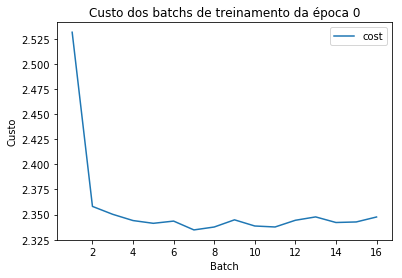

Epoch execution time: 0:01:39.293183
Batch execution time: 0:00:06.083462
Batch execution time: 0:00:05.794858
Batch execution time: 0:00:05.801959
Batch execution time: 0:00:05.855280
Batch execution time: 0:00:05.476997
Batch execution time: 0:00:05.504265
Batch execution time: 0:00:05.778148
Batch execution time: 0:00:05.612629
Batch execution time: 0:00:05.947551
Batch execution time: 0:00:06.201827
Batch execution time: 0:00:05.825829
Batch execution time: 0:00:05.763999
Batch execution time: 0:00:05.587839
Batch execution time: 0:00:05.534596
Batch execution time: 0:00:05.702675
Batch execution time: 0:00:05.907392
cost_by_batch: [(1, 2.2258176373513123), (2, 2.350357328812222), (3, 2.357565120846333), (4, 2.3558576614044404), (5, 2.353382104079112), (6, 2.356030622749965), (7, 2.3540756634007454), (8, 2.355757730364191), (9, 2.368691138880988), (10, 2.3627094296074937), (11, 2.366579861052819), (12, 2.36868862883092), (13, 2.374930673225929), (14, 2.371121187650004), (15, 2.3724

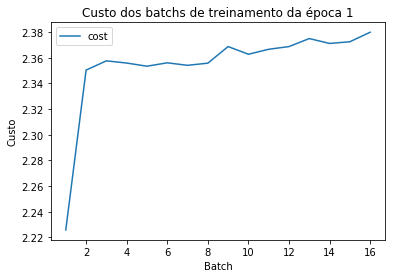

Epoch execution time: 0:01:39.823594
Cost by Epoch: [(0, 2.3476029130623437, 2.2166146781580993), (1, 2.379853080014466, 2.1418402905748724)]


In [128]:
(cost_by_epoch_training_neural, weightsInHiddenConnection, weightsHiddenOutConnection) = train_neural_network(2,weightsInHiddenConnection,weightsHiddenOutConnection,0.01,5000,inputs,-1)


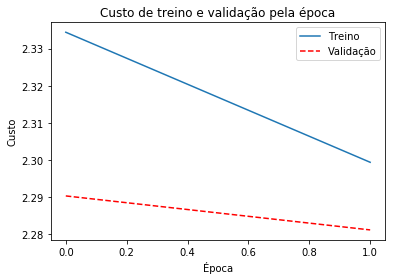

In [124]:
plot_cost_train_val_by_epoch(cost_by_epoch_training_neural)

## Execução 2

In [ ]:
weightsInHiddenConnection2 = get_randomly_initialized_theta(3072,3072,4)

In [ ]:
weightsHiddenOutConnection2 = get_randomly_initialized_theta(3072,10,5)

In [ ]:
(cost_by_epoch_training_neural_ex2, weightsInHiddenConnection_ex2, weightsHiddenOutConnection_ex2) = train_neural_network(10,weightsInHiddenConnection2,weightsHiddenOutConnection2,0.01,5000,inputs,-1)
